In [2]:
import open3d as o3d
import numpy as np
import copy

run_testing = 0

if run_testing:
    

    class GlobalRegistrationFPHPICP():
        def set_parameters(self, voxel_size = 5, max_nn = 30, fast = False, verbose=False):
            self.voxel_size = voxel_size
            self.radius = self.voxel_size * 4
            self.max_nn = max_nn
            self.NORMAL_FAST_COMPUTATION = False
            self.fast = fast
            self.verbose = verbose

        def print_v(self, s):
            if self.verbose:
                print(s)

        def execute_global_registration(self, source_down, target_down, source_fpfh, target_fpfh):
            """
                Reference: http://www.open3d.org/docs/release/tutorial/pipelines/global_registration.html
            """
            source_down = copy.deepcopy(source_down)
            target_down = copy.deepcopy(target_down)

            distance_threshold = self.voxel_size * 1.5
            self.print_v(":: RANSAC registration on downsampled point clouds.")
            self.print_v(f"   Since the downsampling voxel size is {self.voxel_size}")
            self.print_v(f"   we use a liberal distance threshold {distance_threshold}")
            result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
                source_down, target_down, source_fpfh, target_fpfh, True,
                distance_threshold,
                o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
                3, [
                    o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                        0.9),
                    o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                        distance_threshold)
                ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
            return result
        
        def execute_fast_global_registration(self, source_down, target_down, source_fpfh,
                                            target_fpfh):
            distance_threshold = self.voxel_size * 0.5
            self.print_v(f":: Apply fast global registration with distance threshold {distance_threshold}")
            result = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
                source_down, target_down, source_fpfh, target_fpfh,
                o3d.pipelines.registration.FastGlobalRegistrationOption(
                    maximum_correspondence_distance=distance_threshold))
            return result

        def refine_registration(self, source, target, ransac_trans):
            source.estimate_covariances(
                search_param = o3d.geometry.KDTreeSearchParamHybrid(self.radius, max_nn=self.max_nn),
            )
            target.estimate_covariances(
                search_param = o3d.geometry.KDTreeSearchParamHybrid(self.radius, max_nn=self.max_nn),
            )
            # NOTE: TransformationEstimationPointToPlane is used in the 
            distance_threshold = self.voxel_size * 0.4
            self.print_v(":: Point-to-plane ICP registration is applied on original point")
            self.print_v("   clouds to refine the alignment. This time we use a strict")
            self.print_v(f"   distance threshold {distance_threshold}")
            result = o3d.pipelines.registration.registration_icp(
                source, target, distance_threshold, ransac_trans,
                o3d.pipelines.registration.TransformationEstimationForGeneralizedICP())
            return result

        def preprocess_point_cloud(self, pcd):
            pcd = copy.deepcopy(pcd)
            self.print_v(f":: Downsample with a voxel size {self.voxel_size}")
            pcd_down = pcd.voxel_down_sample(self.voxel_size)

            radius_normal = self.voxel_size * 2
            self.print_v(f":: Estimate normal with search radius {radius_normal}")
            pcd_down.estimate_normals(
                o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

            radius_feature = self.voxel_size * 5
            self.print_v(f":: Compute FPFH feature with search radius {radius_feature}")
            pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
                pcd_down,
                o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
            return pcd_down, pcd_fpfh

        def register(self, source, target, trans_init = np.identity(4)):
            source = copy.deepcopy(source)
            target = copy.deepcopy(target)

            # self.voxel_size = 5
            # self.radius = self.voxel_size * 4
            # self.max_nn = 30
            # NORMAL_FAST_COMPUTATION = False

            source_down, source_fpfh = self.preprocess_point_cloud(source)
            target_down, target_fpfh = self.preprocess_point_cloud(target)

            if self.fast:
                result_ransac = self.execute_fast_global_registration(source_down, target_down,
                                                                source_fpfh, target_fpfh)
            else:
                result_ransac = self.execute_global_registration(source_down, target_down,
                                                                source_fpfh, target_fpfh)

            source.estimate_normals(
                search_param = o3d.geometry.KDTreeSearchParamHybrid(self.radius, max_nn=self.max_nn),
                fast_normal_computation=self.NORMAL_FAST_COMPUTATION
            )
            target.estimate_normals(
                search_param = o3d.geometry.KDTreeSearchParamHybrid(self.radius, max_nn=self.max_nn),
                fast_normal_computation=self.NORMAL_FAST_COMPUTATION
            )

            # result_icp = self.refine_registration(source, target, result_ransac.transformation)
            # print(":: Fitness: ", result_icp.fitness)

            # if show:
            #     self.draw_registration_result(source, target, result_icp.transformation)

            return result_ransac.transformation, result_ransac

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
import sys
sys.path.append('C:/Users/AlejandroHVilla/Documents/WPy64-3950/notebooks/3DVisionSystem/mylab')
if run_testing:

    from ICP import *
    from go_icp import *
    from zero_center_registration import *
    # from GlobalRegistrationFPHPICP import *

    # icp_p2p = ICP_P2P()
    # icp_p2p.set_parameters(max_correspondence_distance = 1)

    # icp_p2p = ICP_P2L()
    # icp_p2p.set_parameters(max_correspondence_distance = 1, radius=0.2, max_nn=30, kernel=None)

    # icp_p2p = ICP_Generalized()
    # icp_p2p.set_parameters(max_correspondence_distance = 1, radius=0.2, max_nn=30)

    # icp_go = GO_ICP()
    # icp_go.set_parameters(arg1=200, arg2=2.0, MSEThresh=0.001) # 200, 2)
    # icp_p2p = ZeroCenterRegistration()
    # icp_p2p.set_parameters(icp_go)

    # new_reg_trans, _ = cCReg.register(copy.deepcopy(source_), copy.deepcopy(target_))

    # icp_p2p = GlobalRegistrationFPHPICP() # Ransac
    # icp_p2p.set_parameters(voxel_size = 0.02, max_nn = 30, fast = False)

    # icp_p2p = GlobalRegistrationFPHPICP() # FGR
    # icp_p2p.set_parameters(voxel_size = 0.075, max_nn = 30, fast = True)

    regMetric = RegistrationMetrics()


    for dd in range(0, 5): #  19
        for idx in range(0, 39): # 39

            x, y, gt_R, gt_t = get_point_cloud_data(idx)
            scale = 1
            reg_p2p_pred, reg_p2p = icp_p2p.register(initialize_pointcloud(scale*x.detach().cpu().numpy()[0]),
                                                    initialize_pointcloud(scale*y.detach().cpu().numpy()[0]))

            # draw_registration_result(initialize_pointcloud(scale*x.detach().cpu().numpy()[0]),
            #                          initialize_pointcloud(scale*y.detach().cpu().numpy()[0]), reg_p2p_pred)
            star
            regMetric.add_values(torch.from_numpy(reg_p2p_pred[:3, :3]).view(1,3,3),
                                torch.from_numpy(reg_p2p_pred[:3, 3]).view(1,3),
                                gt_R.view(1,3,3), scale*gt_t.view(1,3))


In [6]:
# DNSS.get_DNSS_pointcloud(source, 2, 0.5, show=False)

############################# CAD VTC SOURCE ############################
# PCD_DENSITY = 20000
# cad_file_path = 'PCDs/VTC/test_00/Assembly_new.stl'
# source = PCUtils.get_pointcloud_from_file(cad_file_path, PCD_DENSITY)

# source_base_transformation = np.array([[0.383232,    -0.923652,    -0.000000,   550.000000],
#                                        [0.000000,     0.000000,    -1.000000,  -200.000000],
#                                        [0.923652,     0.383232,     0.000000,  -100.000000],
#                                        [0.000000,     0.000000,     0.000000,     1.000000]])
# source.transform(source_base_transformation)

# ############################ SOURCE ############################
# working_dir = "PCDs/VTC/3DReconstruction_02/"
# source = reconstructed_workpiece_cropped_removed = PCUtils.get_pointcloud_from_file(f"{working_dir}vtc_3D_reconstruction.ply")
# source

In [7]:
# ############################ TARGET ############################
# TARGET_ID = 2
# working_dir = "PCDs/VTC/3DReconstruction_04/"
# files_names = [zdf_file for zdf_file in sorted(os.listdir(working_dir)) if zdf_file.lower().endswith('.zdf')]

# new_target = PCUtils.get_pointcloud_from_file(working_dir + files_names[TARGET_ID])

# baseTz_poses = [MatrixPose.pose_to_matrix([650.0,  0,  700.0,  -90.0,  0,  -180.0]),
#                 MatrixPose.pose_to_matrix([650.0,  430.0014067382813,  540.673828125,  -180.0,  0.0,  -138.7890006233789]),
#                 MatrixPose.pose_to_matrix([650.0, -430.001, 540.674, 180.0, 0.0, 138.789]),
#                 MatrixPose.pose_to_matrix([950.0, 0.0, 550.0, -90.0, 0.0, 150.0]),
#                 MatrixPose.pose_to_matrix([500.0, 0.0, 920.0, -90.0, 0.0, -180.0]),
#                 MatrixPose.pose_to_matrix([700.0,  0.0,  920.0,  -90.0,  0.0,  -180.0]),
#                 MatrixPose.pose_to_matrix([780.0,  0.0,  920.0,  -90.0,  0.0,  -180.0]),
#                ]

# roi_params = {'corner_x':   200, 'corner_y':    500, 'corner_z':     200,
#               'dimension_x':750, 'dimension_y': 1000, 'dimension_z': 200}

# new_target.transform(baseTz_poses[TARGET_ID])
# new_target = ROI.crop_roi_box(new_target, roi_params)
# new_target = new_target.voxel_down_sample(voxel_size = 1)

# target = NoiseRemoval.remove_statistical_outlier(new_target, nb_neighbors = 500, std_ratio = 2.0)
# #################################################################

# source_ = get_DNSS_pointcloud(source, 2, 0.85, show=False)
# target_ = get_DNSS_pointcloud(target, 2, 0.85, show=False)

# source, target, source_pts, target_pts = gen_source_targte()

# voxel_size = 2.5
# source_ = copy.deepcopy(source).voxel_down_sample(voxel_size)
# target_ = copy.deepcopy(target).voxel_down_sample(voxel_size)

In [8]:
# start_time = time.time()

# glob_reg_ransac_icp = GlobalRegistrationFPHPICP()
# glob_reg_ransac_icp.set_parameters(voxel_size = 5)

# # cCReg = ZeroCenterRegistration()
# # cCReg.set_parameters(glob_reg_ransac_icp)
# # glob_reg_ransac_icp = cCReg

# new_reg_trans, _ = glob_reg_ransac_icp.register(source_, target_)

# draw_registration_result(source_, target_, new_reg_trans)

# # print(":: Metric: ", RegistrationMetric.get_overlap_ratio(source_, target_, 3, new_reg_trans))
# print("--- %s seconds ---" % (time.time() - start_time))

In [9]:
# naive_reg = NaiveRegistration()
# new_reg_trans, _ = naive_reg.register(source_, target_)

# draw_registration_result(source_, target_, new_reg_trans)
# new_reg_trans

In [10]:
# start_time = time.time()

# go_icp_reg = GO_ICP()
# go_icp_reg.set_parameters(200, 2)
# cCReg = ZeroCenterRegistration()
# cCReg.set_parameters(go_icp_reg)

# new_reg_trans, _ = cCReg.register(copy.deepcopy(source_), copy.deepcopy(target_))

# draw_registration_result(source_, target_, new_reg_trans)

# print(":: Metric: ", RegistrationMetric.get_overlap_ratio(source_, target_, 3, new_reg_trans))
# print("--- %s seconds ---" % (time.time() - start_time))

# Gradient Descent Algorithm for Surface Matching as Point Clouds

In [4]:
import matplotlib.pyplot as plt
from data import ModelNet40
import numpy as np
import torch
import copy
import open3d as o3d
from scipy.spatial.transform import Rotation as R
from vtctestregistrationdata import VTCTestRegistrationData
# from vtctestregistrationaugmenteddata import VTCTestRegistrationAugmentedData
from generatedtrainingdata import GeneratedTrainingData
import time

In [5]:
import plotly.graph_objects as go

# Replace Open3D function with plotly for visualization in Google 
def draw_geometries(geometries):

    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()

        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)

            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)

    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

# o3d.visualization.draw_geometries = draw_geometries # replace function

In [13]:
# VTCTestRegistrationAugmentedData('vtc_testing_dataset.hdf5', n_points, meter_scaled=True, Rz_max = 20, Rxy_max = 20, t_max = 0.1)

In [6]:
def draw_registration_result(source, target, transformation, normals=False):
    SIZE_PERCENTAGE = 0.15
    v_size = round(max(source.get_max_bound() - source.get_min_bound()) * SIZE_PERCENTAGE, 4)

    source = copy.deepcopy(source)
    target = copy.deepcopy(target)

    if normals:
        source.estimate_normals(
            search_param = o3d.geometry.KDTreeSearchParamHybrid(0.02, max_nn = 30))

        target.estimate_normals(
            search_param = o3d.geometry.KDTreeSearchParamHybrid(0.02, max_nn = 30))

    coord_syst = o3d.geometry.TriangleMesh.create_coordinate_frame(size=v_size, origin=[0, 0, 0])
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0 ])  # 1, 0.706, 0
    target_temp.paint_uniform_color([0, 0.651, 0.929]) #  # 0, 0.651, 0.929
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp, coord_syst])

def initialize_pointcloud(pts):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts)
    return pcd

#########
# generated_training_data_path = 'generated_training_dataset.hdf5'
# trainset = GeneratedTrainingData(None, generated_training_data_path)

# idx = 2
# test_cts = trainset[idx]
# scaling = 1
# target = initialize_pointcloud(test_cts[0].T.detach().cpu().numpy()*scaling)
# source = initialize_pointcloud(test_cts[1].T.detach().cpu().numpy()*scaling)
# transform = np.eye(4)
# transform[:3, :3] = test_cts[2].detach().cpu().numpy()
# transform[:3, 3] = test_cts[3].detach().cpu().numpy() * scaling

# draw_registration_result(target,source,transform)

In [15]:
import torch
import torch.nn as nn
from pytorch3d.transforms import (matrix_to_quaternion, quaternion_to_matrix, euler_angles_to_matrix, Transform3d)
from pytorch3d.loss import chamfer_distance
import torch.optim as optim
from pytorch3d.ops import (ball_query, knn_points, sample_farthest_points)

class F1ScoreLossCount(nn.Module):
    def __init__(self, threshold, K=10):
        super(F1ScoreLossCount, self).__init__()
        self.threshold = threshold
        self.K = K

    def forward(self, x, y, reduction = 'sum'):
        def get_overlap(x, y):
            b_query = ball_query(y, x, K=self.K, radius = self.threshold)

            # Count the number of points (rows) in each batch where there is at least one non -1 value
            # Create a tensor
            x = (b_query[0]).sum(dim=2) * 1e10

            # Use torch.clamp to create a tensor with values between 0 and 1
            # Values greater than the threshold become 1, and others become 0, x - threshold
            binary_tensor = torch.clamp(x, min=0, max=1.0)

            # Count the number of values greater than the threshold using torch.sum()
            non_negative_points_per_batch = torch.sum(binary_tensor, dim=1)

            total_points_per_batch = torch.tensor([len(batch) for batch in y]).to('cuda')

            overlap_source_on_target = non_negative_points_per_batch / total_points_per_batch
            return overlap_source_on_target

        precision = get_overlap(x, y)
        recall = get_overlap(y, x)
        # print('precision: ', precision)
        # print('recall: ', recall)

        # Return the negative F1 score as a loss (minimizing F1 score is equivalent to maximizing overlap)
        f1_score = 2*(precision * recall)/(precision + recall)

        if reduction == 'sum':
            return -torch.nan_to_num(f1_score, nan=2).sum()
        else:
            return -torch.nan_to_num(f1_score, nan=2).mean()



# x = torch.tensor([[[0,0,0],  [0,0,1],  [0,0,2]],    [[0,0,0],  [0,0,1],  [0,0,2]]]).float().requires_grad_() # source
# y = torch.tensor([[[0.1,0,0],[0.1,0,1],[0,0,2.05]], [[0,0,0],  [0,0,1],  [0,0,2]]]).float().requires_grad_() # template

# x = torch.tensor([[[0,0,0],    [0,0,0],    [0,0,5]],    ]).float().requires_grad_() # source
# y = torch.tensor([[[0.01,0,0], [0,0,1.01], [0,0,1.05]]  ]).float().requires_grad_() # template

# # Usage:
# loss_function = F1ScoreLossCount(0.05)
# print(loss_function(x, y), loss_function(y, x))

# loss_function = F1ScoreLoss(0.05)
# print(loss_function(x, y), loss_function(y, x))

In [16]:
# corresponding_points_alignment
# pytorch3d.ops.box3d_overlap

In [17]:
# sum_dist_per_point = (dist_matrix).sum(dim=1) # dist_matrix = P1 X K
# sum_of_all_points = torch.sum(sum_dist_per_point, dim=0) # where sum_of_all_points is of size P1

In [18]:
class F1ScoreLoss(nn.Module):
    def __init__(self, threshold, K=10):
        super(F1ScoreLoss, self).__init__()
        self.threshold = threshold
        self.K = K

    def forward(self, x, y, reduction = 'sum'):
        def get_overlap(x, y):
            b_query = ball_query(y, x, K=self.K, radius = self.threshold)

            # print('b_query[0]: ', b_query[0])
            # Count the distance of points (rows) in each batch where there is at least one non -1 value
            x = (b_query[0]).sum(dim=2) # Index 0: Tensor of shape (N, P1, K) giving the squared distances to the neighbors.
            # It sums the distance of the overlapping
            # print('x: ', x)
            non_negative_points_per_batch = torch.sum(x, dim=1)

            return non_negative_points_per_batch

        precision = get_overlap(x, y)
        recall = get_overlap(y, x)

        # Return the F1 score as a loss (minimizing F1 score is equivalent to maximizing overlap)
        f1_score = 2*(precision * recall)/(precision + recall)
        if reduction == 'sum':
            return torch.nan_to_num(f1_score, nan=0).sum()
        elif reduction == 'mean':
            return torch.nan_to_num(f1_score, nan=0).mean()
        else:
            return torch.nan_to_num(f1_score, nan=0)

# x = torch.tensor([[[0,0,0],  [0,0,1],  [0,0,2]],    [[0,0,0],  [0,0,1],  [0,0,2]]]).float().requires_grad_() # source
# y = torch.tensor([[[0.1,0,0],[0.1,0,1],[0,0,2.05]], [[0,0,0],  [0,0,1],  [0,0,2]]]).float().requires_grad_() # template

# x = torch.tensor([[[0,0,0],  [0,0,0.05],  [0,0,2]]    ]).float().requires_grad_() # source
# y = torch.tensor([[[0.01,0,0],[0.1,0,1],[0,0,2.05],[0,0,2.05]] ]).float().requires_grad_() # template

# # Usage:
# loss_function = F1ScoreLoss(0.05)
# loss_function(x, y) #, loss_function(y, x)

In [19]:
class NoiseRemoval():
    @staticmethod
    def __display_inlier_outlier(cloud, ind):
        inlier_cloud = cloud.select_by_index(ind)
        outlier_cloud = cloud.select_by_index(ind, invert=True)

        print("Showing outliers (red) and inliers (gray): ")
        outlier_cloud.paint_uniform_color([1, 0, 0])
        inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
        o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

    @staticmethod
    def check_pointcloud(obj):
        if torch.is_tensor(obj):
            print("it is tensor")
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(obj.detach().cpu().numpy())
            from_type = "torch"
        else:
            print("no tensor")
        return pcd, from_type

    @staticmethod
    def remove_statistical_outlier(pcd, nb_neighbors = 600, std_ratio = 2.0, show = False):
        """ 
            Inputs:
                nb_neighbors (int) – Number of neighbors around the target point.
                std_ratio (float) – Standard deviation ratio.
        """
        
        pcd, from_type = NoiseRemoval.check_pointcloud(pcd)

        _, ind = pcd.remove_statistical_outlier(nb_neighbors, std_ratio, print_progress=False)
        if show:
            NoiseRemoval.__display_inlier_outlier(pcd, ind)

        pcd = pcd.select_by_index(ind)

        if from_type == "torch":
            pcd = torch.from_numpy(np.asarray(pcd.points))

        return pcd

# print("Radius oulier removal")
#     cl, ind = voxel_down_pcd.remove_radius_outlier(nb_points=16, radius=0.05)
#     display_inlier_outlier(voxel_down_pcd, ind)

In [20]:
# sample_farthest_ponits(torch.rand(1,2048,3), lengths=torch.tensor([2048]), K=1024)[1]

In [21]:
# x = sample_farthest_points(x, lengths=torch.tensor([2048]), K=1024)[0]
# def sample_farthest_points(
#     points: torch.Tensor,
#     lengths: Optional[torch.Tensor] = None,
#     K: Union[int, List, torch.Tensor] = 50,
#     random_start_point: bool = False,
# ) -> Tuple[torch.Tensor, torch.Tensor]:
# using sample_farthest_points worsen the aligment due to the homogeneous sampling of points acrros all the point cloud which increases the probability of adding outliers in non dense areas

# x = sample_farthest_points(x.view(1,N_before_sampling,3), torch.Tensor([N_before_sampling]), N)[0].view(N,3)
# y = sample_farthest_points(y.view(1,N_before_sampling,3), torch.Tensor([N_before_sampling]), N)[0].view(N,3)

In [22]:
def projected_chamfer_loss(x, y):
    def get_projected_point_cloud(x, y, dim=0):
        x_cln = x.clone()
        y_cln = y.clone()

        x_cln[:,:,dim] = 0
        y_cln[:,:,dim] = 0

        return x_cln, y_cln

    x_yz, y_yz = get_projected_point_cloud(x, y, dim=0)
    x_xz, y_xz = get_projected_point_cloud(x, y, dim=1)
    x_xy, y_xy = get_projected_point_cloud(x, y, dim=2)
    
    cd_yx, _ = chamfer_distance(x_yz,y_yz)
    cd_xx, _ = chamfer_distance(x_xz,y_xz)
    cd_xy, _ = chamfer_distance(x_xy,y_xy)

    return cd_yx + cd_xx + cd_xy

# import torch.nn.functional as F

# class RigidMotionLoss(nn.Module):
#     def __init__(self):
#         super(RigidMotionLoss, self).__init__()
#         self.discount_factor = 1

#     def forward(self, rotation_ab, translation_ab, rotation_ba, translation_ba, iteration_n = 1):
#         """
#             This function takes the transformation as normal and inverse (scr_T_tgt and tgt_T_scr)
#             to compute the loss
#         """
#         batch_size = rotation_ab.size(0)
#         identity = torch.eye(3, device=rotation_ab.device).unsqueeze(0).repeat(batch_size, 1, 1)
#         return (F.mse_loss(torch.matmul(rotation_ba.transpose(2, 1), rotation_ab), identity) \
#                 + F.mse_loss(translation_ba, translation_ab)) * self.discount_factor**iteration_n

# class FrobeniusNormLoss(nn.Module):
#     def __init__(self):
#         super(FrobeniusNormLoss, self).__init__()

#     def frobeniusNormLoss(self, predicted, igt, batch_reduction='mean'):
#         """
#             This function computes the loss based on the ground-thruth
#             |predicted*igt - I| (should be 0)
#             args:
#                 predicted: Bx4x4 Homogeneous matrix
#                 igt: Bx4x4 Homogeneous matrix
#         """
#         assert predicted.size(0) == igt.size(0)
#         assert predicted.size(1) == igt.size(1) and predicted.size(1) == 4
#         assert predicted.size(2) == igt.size(2) and predicted.size(2) == 4

#         error = predicted.matmul(igt)
#         I = torch.eye(4).to(error).view(1, 4, 4).expand(error.size(0), 4, 4)
#         return torch.nn.functional.mse_loss(error, I, reduction=batch_reduction) * 16

#     def forward(self, predicted, igt):
#         return self.frobeniusNormLoss(predicted, igt)

# class CycleConsistencyLoss(nn.Module):
#     def __init__(self):
#         super(CycleConsistencyLoss, self).__init__()
#         self.cycle_consistency_loss = 1
#         self.discount_factor = 1

#     def forward(self, rotation_ab, translation_ab, rotation_ba, translation_ba, iteration_n=1):
#         """
        
#         """
#         batch_size = rotation_ab.size(0)
#         identity = torch.eye(3, device=rotation_ab.device).unsqueeze(0).repeat(batch_size, 1, 1)
#         return F.mse_loss(torch.matmul(rotation_ab, rotation_ba), identity) \
#                + F.mse_loss(translation_ab, -translation_ba) * self.cycle_consistency_loss * self.discount_factor**iteration_n


In [23]:
import numpy as np
from pytorch3d.transforms import (matrix_to_quaternion, quaternion_to_matrix, euler_angles_to_matrix, 
                                  quaternion_apply, Transform3d)

def get_initial_quaternions():
    # Define the range (-A to A) for the rotations
    A = 5 #20  # Replace with your desired range in degrees

    # Number of divisions or steps within the range
    num_steps = 4  # Adjust this to your desired number of steps

    # Generate the grid of Euler rotations
    x_angles = np.linspace(-A, A, num_steps)
    y_angles = np.linspace(-A, A, num_steps)

    # Create a grid of Euler rotations using meshgrid
    x_rotations, y_rotations = np.meshgrid(np.radians(x_angles), np.radians(y_angles))

    # Stack the X and Y rotations into a single array
    x_rotations_rav = x_rotations.ravel()
    n_initial_quat = x_rotations_rav.shape[0]

    rotations = np.column_stack((np.zeros(n_initial_quat), y_rotations.ravel(), x_rotations_rav))

    if num_steps % 2 == 0:
        rotations = np.vstack([np.array([0,0,0]), rotations])
        n_initial_quat += 1

    rotations = torch.from_numpy(rotations).float()

    # Now, 'rotations' contains the grid of Euler rotations in a single 2D array

    initial_quaternions = matrix_to_quaternion(euler_angles_to_matrix(rotations, "XYZ"))

    return n_initial_quat, initial_quaternions

In [24]:
# This function returns the initialized quaternions for highly densed kernel across the +/-180° in the SE(3) search space
# def get_initial_quaternions():
#     # Define the range (-A to A) for the rotations
#     A = 180  # Replace with your desired range in degrees
#     B = 20

#     # Number of divisions or steps within the range
#     num_steps = 20  # Adjust this to your desired number of steps

#     # Generate the grid of Euler rotations
#     x_angles = np.linspace(-B, B, 4)
#     y_angles = np.linspace(-A, A, num_steps)

#     # Create a grid of Euler rotations using meshgrid
#     x_rotations, y_rotations = np.meshgrid(np.radians(x_angles), np.radians(y_angles))

#     # Stack the X and Y rotations into a single array
#     x_rotations_rav = x_rotations.ravel()
#     n_initial_quat = x_rotations_rav.shape[0]

#     rotations = np.column_stack((np.zeros(n_initial_quat), x_rotations_rav, y_rotations.ravel() )) # x_rotations_rav

#     if num_steps % 2 == 0:
#         rotations = np.vstack([np.array([0,0,0]), rotations])
#         n_initial_quat += 1

#     rotations = torch.from_numpy(rotations).float()

#     # Now, 'rotations' contains the grid of Euler rotations in a single 2D array

#     initial_quaternions = matrix_to_quaternion(euler_angles_to_matrix(rotations, "XYZ"))

#     return n_initial_quat, initial_quaternions

In [25]:
from data import ModelNet40

# trainset = ModelNet40(num_points=2048,
#                       num_subsampled_points=1800,
#                       partition='train', gaussian_noise=True,
#                       unseen=True, rot_factor=10)

In [26]:
class RMSEInlierLoss(nn.Module):
    def __init__(self):
        super(RMSEInlierLoss, self).__init__()
        pass

    def forward(self, x, y_transformed, batch_reduction=None):
        """
            Inlier_rmse, which measures the RMSE of all inlier correspondences.
            The lower, the better.
        """
        nn_dist = knn_points(x, y_transformed, K=1, return_nn=True)[0]
        if batch_reduction == None:
            rmse_scores = torch.sqrt(nn_dist.sum(axis=1))
        elif batch_reduction == 'sum':
            rmse_scores = torch.sqrt(nn_dist.sum(axis=1)).sum()
        elif batch_reduction == 'mean':
            rmse_scores = torch.sqrt(nn_dist.sum(axis=1)).mean()

        return rmse_scores

In [27]:
o3d.utility.set_verbosity_level(o3d.utility.VerbosityLevel.Warning)

class HandPickPoints():
    @staticmethod
    def hand_pick_points(pcd: o3d.geometry.PointCloud) -> np.ndarray:
        """
            Functions called when point selection changes.
        """
        def get_picked_points():
            pts = vis.get_picked_points()

        vis = o3d.visualization.VisualizerWithVertexSelection()
        vis.create_window()
        vis.add_geometry(pcd)
        # Press Shift+Left Mouse click to select a point
        vis.register_selection_changed_callback(get_picked_points)
        vis.run()
        pts = vis.get_picked_points()
        vis.destroy_window()

        picked_points = np.empty((0,2), np.double)
        for i, pt in enumerate(pts):
            picked_points = np.vstack([picked_points, [getattr(pt, 'coord'), getattr(pt, 'index')]])

        return picked_points

    @staticmethod
    def get_hand_pick_points(pcd: o3d.geometry.PointCloud) -> o3d.geometry.PointCloud:
        pcd = copy.deepcopy(pcd)
        selected_points = HandPickPoints.hand_pick_points(pcd)

        pcd_cad = o3d.geometry.PointCloud()
        pcd_cad.points = o3d.utility.Vector3dVector(selected_points[:,0])
        return pcd_cad

    @staticmethod
    def get_hand_pick_points_np(pcd: np.ndarray) -> np.ndarray:
        
        # Convert numpy point cloud to o3d
        pcd_o3d = o3d.geometry.PointCloud()
        pcd_o3d.points = o3d.utility.Vector3dVector(pcd[:, :3])
       
        # Pick points
        selected_points = HandPickPoints.hand_pick_points(pcd_o3d)[:,0]
        
        # Return picked point cloud as np
        return np.concatenate(selected_points).reshape(selected_points.shape[0], 3)


In [28]:
import torch
from torch.utils.data import Dataset
import numpy as np
from scipy.spatial.transform import Rotation as R
import h5py
import random
from corruptedpointcloud import CorruptedPointCloud

class VTCTestRegistrationDataRandom(Dataset):
    """
        It returns the real data dataset of VTC part but with randomized initial rotations in the given range.
        Since it's real data, it does not include further data corruptions.
    """
    def __init__(self, dataset_path, n_points, meter_scaled=True, Rz_max = 20, Rxy_max = 20, t_max = 0.1, manual_point_pick = False, severity=2):
        self.dataset_path = dataset_path
        self.n_points = n_points
        self.meter_scaled = meter_scaled
        self.scale_factor = 2.3
        self.manual_point_pick = manual_point_pick

        if isinstance(Rz_max, (list, tuple)):
            self.Rz_max = Rz_max[1]
            self.Rz_min = Rz_max[0]
        else:
            self.Rz_max = Rz_max
            self.Rz_min = -Rz_max

        if isinstance(Rxy_max, (list, tuple)):
            self.Rxy_max = Rxy_max[1]
            self.Rxy_min = Rxy_max[0]
        else:
            self.Rxy_max = Rxy_max
            self.Rxy_min = -Rxy_max

        self.t_max = t_max

        self.severity = severity

        with h5py.File(self.dataset_path, "r") as f:
            self.source = f['source']
            self.source = self.uniform_downsample_point_cloud(np.asarray(self.source), n_points)
            self.dataset_size = f['targets'].shape[0]

        # if not self.meter_scaled:
        self.source = self.source * self.scale_factor
        self.source = torch.from_numpy(self.source).float()

    def uniform_downsample_point_cloud(self, point_cloud, num_points: int) -> np.ndarray:
        """
        Uniformly downsamples a point cloud to a given number of points.

        Args:
            point_cloud (numpy.ndarray): The original point cloud of shape (N, 3).
            num_points (int): The desired number of points in the downsampled point cloud.

        Returns:
            numpy.ndarray: The downsampled point cloud of shape (num_points, 3).
        """
        np.random.seed(42)
        if not isinstance(point_cloud, np.ndarray):
            point_cloud = np.asarray(point_cloud.points)

        # Ensure num_points is within the range [1, len(point_cloud)]
        num_points = max(1, min(len(point_cloud), num_points))

        # Shuffle the indices of the original point cloud
        indices = np.arange(len(point_cloud))
        np.random.shuffle(indices)

        # Select the first num_points indices and create the downsampled point cloud
        downsampled_point_cloud = point_cloud[indices[:num_points]]

        return downsampled_point_cloud

    def __len__(self):
        return self.dataset_size
    
    def get_transformations(self, igt):
        R_ba = igt[:, 0:3, 0:3]								# Ps = R_ba * Pt
        translation_ba = igt[:, 0:3, 3].unsqueeze(2)		# Ps = Pt + t_ba
        R_ab = R_ba.permute(0, 2, 1)						# Pt = R_ab * Ps
        translation_ab = -torch.bmm(R_ab, translation_ba)	# Pt = Ps + t_ab
        return R_ab[0], translation_ab[0], R_ba[0], translation_ba[0]

    def apply_transform(self, points: np.ndarray, transform: np.ndarray) -> np.ndarray:
        rotation = transform[:3, :3]
        translation = transform[:3, 3]
        points = np.matmul(points, rotation.T) + translation
        return points

    def get_identity_transformation_matrix(self):
        return np.eye(4)

    def get_random_transformation_matrix(self):
        t_max = self.t_max

        # Random translation vector
        t = [random.uniform(-t_max,t_max),
             random.uniform(-t_max,t_max),
             random.uniform(-t_max,t_max)]

        # Random Euler rotation as rotation matrix
        r = R.from_euler('xyz', [random.uniform(self.Rz_min,  self.Rz_max),
                                 random.uniform(self.Rxy_min, self.Rxy_max),
                                 random.uniform(self.Rxy_min, self.Rxy_max)],
                                 degrees=True).as_matrix()
        
        transform = np.eye(4)
        transform[:3, :3] = r
        transform[:3, 3] = t
        
        return transform

    def __getitem__(self, index):
        # index = random.randint(0, 38)
        with h5py.File(self.dataset_path, "r") as f:
            template = np.asarray(f['targets'][index])

            igt = np.asarray(f['transformations'][index])
            self.source = self.uniform_downsample_point_cloud(np.asarray(f['source']), self.n_points) * self.scale_factor

            # Manual pick selection of points in the template point cloud, if requested          
            if self.manual_point_pick:
                template = HandPickPoints.get_hand_pick_points_np(template)
                self.source = HandPickPoints.get_hand_pick_points_np(self.source)

            self.source = torch.from_numpy(self.source).float()
        
        # Restore initial misaligments
        template = self.apply_transform(template, np.linalg.inv(igt))
        # Get and apply new transformation matrix according to new parameters (max rotations and translation)
        igt = self.get_random_transformation_matrix()
        template = self.apply_transform(template, igt)        
        
        # if not self.meter_scaled:
        template = template * self.scale_factor
        igt[:3,3] = igt[:3,3] * self.scale_factor


        igt = torch.from_numpy(igt).float() # igt 4x4, source -> target
        template = self.uniform_downsample_point_cloud(template, self.n_points)
        template = torch.from_numpy(np.asarray(template)).float()

        R_ab, translation_ab, R_ba, translation_ba = self.get_transformations(igt.view(1,4,4))
        euler_ab = torch.from_numpy(R.from_matrix(R_ab.detach().cpu().numpy()).as_euler('zyx')).float()
        euler_ba = torch.from_numpy(R.from_matrix(R_ba.detach().cpu().numpy()).as_euler('zyx')).float()
        
        # torch.Size([2, 3, 3]) torch.Size([2, 3]) torch.Size([2, 3, 3]) torch.Size([2, 3]) torch.Size([2, 3]) torch.Size([2, 3])
        
        # a, b, R_ab, t_at, R_ba, t_ba
        return template.T, self.source.T, R_ab, translation_ab.view(3), R_ba, translation_ba.view(3), euler_ab.view(3), euler_ba.view(3)


In [29]:
import numpy as np
import copy
import open3d as o3d
import torch
import random

class CorruptedPointCloud():
    """
        References:
        https://github.com/jiachens/ModelNet40-C
    """
    
    def __init__(self, pc):
        self.pc = copy.deepcopy(pc)
        self.ORIG_NUM = pc.shape[0]

    def get_original(self):
        return self.pc
    
    def uniform_sampling(self, severity):
        pointcloud = self.pc
        N, C = pointcloud.shape
        c = [N//15, N//10, N//8, N//6, N//2, 3 * N//4][severity-1]
        index = np.random.choice(self.ORIG_NUM, self.ORIG_NUM - c, replace=False)
        return pointcloud[index]
    
    def random_shuffle_points(self):
        """Randomly permute point cloud."""
        points = self.pc
        indices = np.random.permutation(points.shape[0])
        points = points[indices]
        return points

    def normalize_points_1(self):
        new_pc = self.pc
        new_pc[:,0] -= (np.max(new_pc[:,0]) + np.min(new_pc[:,0])) / 2
        new_pc[:,1] -= (np.max(new_pc[:,1]) + np.min(new_pc[:,1])) / 2
        new_pc[:,2] -= (np.max(new_pc[:,2]) + np.min(new_pc[:,2])) / 2
        leng_x, leng_y, leng_z = np.max(new_pc[:,0]) - np.min(new_pc[:,0]), np.max(new_pc[:,1]) - np.min(new_pc[:,1]), np.max(new_pc[:,2]) - np.min(new_pc[:,2])
        if leng_x >= leng_y and leng_x >= leng_z:
            ratio = 2.0 / leng_x
        elif leng_y >= leng_x and leng_y >= leng_z:
            ratio = 2.0 / leng_y
        else:
            ratio = 2.0 / leng_z
        new_pc *= ratio
        return new_pc, ratio

    def normalize_points(self):
        """GEOTRANSFORMER: Normalize point cloud to a unit sphere at origin."""
        points = self.pc
        points = points - points.mean(axis=0)
        factor = 1 / np.max(np.linalg.norm(points, axis=1))
        points = points * factor
        return points, factor

    def uniform_downsample_fixed_number_of_points(self, num_points) -> np.ndarray:
        """
        Uniformly downsamples a point cloud to a given number of points.

        Args:
            point_cloud (numpy.ndarray): The original point cloud of shape (N, 3).
            num_points (int): The desired number of points in the downsampled point cloud.

        Returns:
            numpy.ndarray: The downsampled point cloud of shape (num_points, 3).
        """
        point_cloud = self.pc
        np.random.seed(42)

        # Ensure num_points is within the range [1, len(point_cloud)]
        num_points = max(1, min(len(point_cloud), num_points))

        # Shuffle the indices of the original point cloud
        indices = np.arange(len(point_cloud))
        np.random.shuffle(indices)

        # Select the first num_points indices and create the downsampled point cloud
        downsampled_point_cloud = point_cloud[indices[:num_points]]

        
        return downsampled_point_cloud

    # Density Corruption Patterns
    # {Occlusion, LiDAR, LocalDensityInc, LocalDensityDec, Cutout}
    def occlusion(self, severity):
        ## severity here does not stand for real severity ##
        original_data = self.pc
        new_pc = occlusion_1(original_data, 'occlusion', severity, n_points=1024)

        theta =  -np.pi / 2.
        gamma =  0
        beta = np.pi

        matrix_1 = np.array([[1,0,0],[0,np.cos(theta),-np.sin(theta)],[0,np.sin(theta),np.cos(theta)]])
        matrix_2 = np.array([[np.cos(gamma),0,np.sin(gamma)],[0,1,0],[-np.sin(gamma),0,np.cos(gamma)]])
        matrix_3 = np.array([[np.cos(beta),-np.sin(beta),0],[np.sin(beta),np.cos(beta),0],[0,0,1]])
        
        new_pc = np.matmul(new_pc,matrix_1)
        new_pc = np.matmul(new_pc,matrix_2)
        new_pc = normalize(np.matmul(new_pc,matrix_3).astype('float32'))

        pointcloud.append(new_pc)

        pointcloud = np.stack(pointcloud,axis=0)

        return pointcloud

    def cutout(self, severity):
        '''
            Cutout several part in the point cloud
        '''
        pointcloud = self.pc
        N, C = pointcloud.shape
        # c = [(2,20), (3,30), (5,30), (7,30), (10,40)][severity-1]
        # 5.1: (10,40)
        c = [(2,20), (3,30), (5,30), (7,30), (10,175)][severity-1]
        print(c)
        for _ in range(c[0]):
            # It selects a random point index of the point cloud in 'picked'
            i = np.random.choice(pointcloud.shape[0],1)
            picked = pointcloud[i]
            # Computes Euclidean distances between each point and the picked point
            dist = np.sum((pointcloud - picked)**2, axis=1, keepdims=True)
            idx = np.argpartition(dist, c[1], axis=0)[:c[1]]
            # pointcloud[idx.squeeze()] = 0
            # It deletes selected points
            pointcloud = np.delete(pointcloud, idx.squeeze(), axis=0)

        return pointcloud
 
    def density_inc(self, severity):
        '''
        Density-based up-sampling the point cloud
        '''
        # TODO: 1024 is the number of points it returns
        pointcloud = self.pc
        N, C = pointcloud.shape
        c = [(1,100), (2,100), (3,100), (4,100), (5,100)][severity-1]
        # idx = np.random.choice(N,c[0])
        temp = []
        for _ in range(c[0]):
            i = np.random.choice(pointcloud.shape[0],1)
            picked = pointcloud[i]
            dist = np.sum((pointcloud - picked)**2, axis=1, keepdims=True)
            idx = np.argpartition(dist, c[1], axis=0)[:c[1]]
            # idx_2 = np.random.choice(c[1],int((3/4) * c[1]),replace=False)
            # idx = idx[idx_2]
            temp.append(pointcloud[idx.squeeze()])
            pointcloud = np.delete(pointcloud, idx.squeeze(), axis=0)
        
        idx = np.random.choice(pointcloud.shape[0], 1024 - c[0] * c[1])
        temp.append(pointcloud[idx.squeeze()])

        pointcloud = np.concatenate(temp)
        # print(pointcloud.shape)
        return pointcloud

    def density(self, severity):
        '''
        Density-based sampling the point cloud
        '''
        pointcloud = self.pc
        N, C = pointcloud.shape
        c = [(1,100), (2,100), (3,100), (4,100), (5,100)][severity-1]
        for _ in range(c[0]):
            i = np.random.choice(pointcloud.shape[0],1)
            picked = pointcloud[i]
            dist = np.sum((pointcloud - picked)**2, axis=1, keepdims=True)
            idx = np.argpartition(dist, c[1], axis=0)[:c[1]]
            idx_2 = np.random.choice(c[1],int((3/4) * c[1]),replace=False)
            idx = idx[idx_2]
            pointcloud = np.delete(pointcloud, idx.squeeze(), axis=0)
            # pointcloud[idx.squeeze()] = 0
        # print(pointcloud.shape)
        return pointcloud

    def camera_point_of_view(self, severity) -> np.array:
        """
            Crop point cloud from a point of view using Open3D from +Z (diameter) camera position
        """
        def initialize_pointcloud(pts: np.array) -> o3d.geometry.PointCloud:
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(pts)
            return pcd

        def get_pcd_diameter(pcd: o3d.geometry.PointCloud) -> float:
            return np.linalg.norm(np.asarray(pcd.get_max_bound()) - np.asarray(pcd.get_min_bound()))

        def get_view_point(pcd: o3d.geometry.PointCloud, cam_loc, rad_factor) -> o3d.geometry.PointCloud:
            """
                args:
                    PCD: Open3D point cloud
                    cam_loc: 2 or 3 long list, if 2, computes the z dimension based on the diameter, else take it as is.
                    rad_factor: Factor multiplier for the diamter to compute the camera radius.
            """

            # pcd = copy.deepcopy(pcd)
            diameter = get_pcd_diameter(pcd)

            if len(cam_loc) == 2:
                camera = [cam_loc[0], cam_loc[1], diameter]
            else:
                camera = cam_loc

            radius = diameter * rad_factor
            # print(f"Camera: {camera}, Diameter is: {diameter}, Radius: {radius}")
            _, pt_map = pcd.hidden_point_removal(camera, radius)
            pcd_viewpoint = pcd.select_by_index(pt_map)

            # Camera point
            # cam_representation = o3d.geometry.TriangleMesh.create_sphere(radius=diameter/30)
            # cam_representation = cam_representation.translate(np.array(camera, np.double))

            return pcd_viewpoint#, cam_representation

        np_pc = self.pc
        o3d_pc = initialize_pointcloud(np_pc)
        diameter = get_pcd_diameter(o3d_pc) * 1
        # Camera location: [-,-,diameter]
        o3d_pc_VOF = get_view_point(o3d_pc, [random.uniform(-diameter,diameter), random.uniform(-diameter,diameter)], 300)

        return np.array(o3d_pc_VOF.points)

    def farthest_subsample_points(self, severity):
        from sklearn.neighbors import NearestNeighbors
        from scipy.spatial.distance import minkowski
        
        pointcloud1 = self.pc
        N, C = pointcloud1.shape
        num_subsampled_points = [int(N*0.95),int(N*0.85),int(N*0.75),int(N*0.65),int(N*0.55)][severity-1]

        num_points = pointcloud1.shape[0]
        nbrs1 = NearestNeighbors(n_neighbors=num_subsampled_points, algorithm='auto',
                                 metric=lambda x, y: minkowski(x, y)).fit(pointcloud1[:, :3])
        random_p1 = np.random.random(size=(1, 3)) + np.array([[500, 500, 500]]) * np.random.choice([1, -1, 1, -1])
        idx1 = nbrs1.kneighbors(random_p1, return_distance=False).reshape((num_subsampled_points,))
        gt_mask = torch.zeros(num_points).scatter_(0, torch.tensor(idx1), 1)
        # YOU MAY ALSO GET THE MASK , gt_mask
        return pointcloud1[idx1, :]

    def random_crop_point_cloud_with_plane(self, severity, p_normal=None):
        def random_sample_plane():
            """Random sample a plane passing the origin and return its normal."""
            phi = np.random.uniform(0.0, 2 * np.pi)  # longitude
            theta = np.random.uniform(0.0, np.pi)  # latitude

            x = np.sin(theta) * np.cos(phi)
            y = np.sin(theta) * np.sin(phi)
            z = np.cos(theta)
            normal = np.asarray([x, y, z])

            return normal

        """GEOTRANSFORMER: Random crop a point cloud with a plane and keep num_samples points."""
        keep_ratio = [0.95, 0.85, 0.75, 0.55, 0.45][severity-1]
        points = self.pc
        num_samples = int(np.floor(points.shape[0] * keep_ratio + 0.5))
        if p_normal is None:
            p_normal = random_sample_plane()  # (3,)
        distances = np.dot(points, p_normal)
        sel_indices = np.argsort(-distances)[:num_samples]  # select the largest K points
        points = points[sel_indices]
        return points

    # Noise Corruption Patterns
    # {Uniform, Gaussian, Impulse, Upsampling, Background}
    
    def uniform_noise(self, severity=1):
        '''
            Add Uniform noise to point cloud 
        '''
        pointcloud = self.pc
        N, C = pointcloud.shape
        c = [0.01, 0.02, 0.03, 0.04, 0.05][severity-1]
        jitter = np.random.uniform(-c,c,(N, C))
        new_pc = (pointcloud + jitter).astype('float32')
        return new_pc

    def gaussian_noise(self, severity):
        pointcloud = self.pc
        N, C = pointcloud.shape
        c = [0.01, 0.015, 0.02, 0.025, 0.03][severity-1]
        jitter = np.random.normal(size=(N, C)) * c
        new_pc = (pointcloud + jitter).astype('float32')
        new_pc = np.clip(new_pc,-1,1)
        return new_pc
    
    def impulse_noise(self, severity):
        pointcloud = self.pc
        N, C = pointcloud.shape
        c = [N//30, N//25, N//20, N//15, N//10][severity-1]
        index = np.random.choice(self.ORIG_NUM, c, replace=False)
        pointcloud[index] += np.random.choice([-1,1], size=(c,C)) * 0.1
        return pointcloud

    def upsampling(self, severity):
        pointcloud = self.pc
        N, C = pointcloud.shape
        c = [N//5, N//4, N//3, N//2, N][severity-1]
        index = np.random.choice(self.ORIG_NUM, c, replace=False)
        add = pointcloud[index] + np.random.uniform(-0.05,0.05,(c, C))
        new_pc = np.concatenate((pointcloud,add),axis=0).astype('float32')
        return new_pc
    
    def background_noise(self, severity):
        pointcloud = self.pc
        N, C = pointcloud.shape
        c = [N//45, N//40, N//35, N//30, N//20][severity-1]
        jitter = np.random.uniform(-1,1,(c, C))
        new_pc = np.concatenate((pointcloud,jitter),axis=0).astype('float32')
        return new_pc

    def jitter_pointcloud(self, clip=0.05):
        ####### learining3D, PRNet, PRCNet
        # N, C = pointcloud.shape
        pointcloud = self.pc
        N, C = pointcloud.shape
        sigma = 0.005*np.random.random_sample()
        pointcloud += np.clip(sigma * np.random.randn(N, C), -1 * clip, clip)
        return pointcloud

    # Transformation Corruptions Patterns
    # {Rotation, Shear, FFD, RBF, InvRBF}
    def shear(self, severity):
        pointcloud = self.pc
        N, C = pointcloud.shape
        c = [0.05, 0.1, 0.15, 0.2, 0.25][severity-1]
        a = np.random.uniform(c-0.05,c+0.05) * np.random.choice([-1,1])
        b = np.random.uniform(c-0.05,c+0.05) * np.random.choice([-1,1])
        d = np.random.uniform(c-0.05,c+0.05) * np.random.choice([-1,1])
        e = np.random.uniform(c-0.05,c+0.05) * np.random.choice([-1,1])
        f = np.random.uniform(c-0.05,c+0.05) * np.random.choice([-1,1])
        g = np.random.uniform(c-0.05,c+0.05) * np.random.choice([-1,1])

        matrix = np.array([[1,0,b],[d,1,e],[f,0,1]])
        new_pc = np.matmul(pointcloud,matrix).astype('float32')
        return new_pc



In [30]:
class CADRegistrationDataRandom(VTCTestRegistrationDataRandom):

    def __init__(self, dataset_path, n_points, meter_scaled = 1, Rz_max = 20, Rxy_max = 20, t_max = 0.5, severity = 2):
        self.dataset_path = dataset_path
        self.n_points = n_points
        self.meter_scaled = meter_scaled
        self.scale_factor = 1

        if isinstance(Rz_max, (list, tuple)):
            self.Rz_max = Rz_max[1]
            self.Rz_min = Rz_max[0]
        else:
            self.Rz_max = Rz_max
            self.Rz_min = -Rz_max

        if isinstance(Rxy_max, (list, tuple)):
            self.Rxy_max = Rxy_max[1]
            self.Rxy_min = Rxy_max[0]
        else:
            self.Rxy_max = Rxy_max
            self.Rxy_min = -Rxy_max

        self.t_max = t_max

        self.severity = severity

    def __getitem__(self, index):

        # 'C:/Users/AlejandroHVilla/Documents/WPy64-3950/notebooks/3DVisionSystem/PCDs/Bathtub/Bath_tub_section.stl'

        cad_pc = o3d.io.read_triangle_mesh(
            'C:/Users/AlejandroHVilla/Documents/WPy64-3950/notebooks/3DVisionSystem/PCDs/VTC/test_00/VTC_from_RoboDK_01.stl').sample_points_uniformly(2048, use_triangle_normal=False)
        pc_np = np.asarray(cad_pc.points)
        pc_np = pc_np - np.mean(pc_np, axis=0)
        source = pc_np * 1/np.max(pc_np)
        # source = template
        # self.source = torch.from_numpy(template).float().view(-1,3)

        # Settings
        n_points = self.n_points

        source, _ = CorruptedPointCloud(source).normalize_points()

        igt = self.get_identity_transformation_matrix()
        # igt = self.get_random_transformation_matrix()
        # At this point, it gets Target and Source with random rotation
        template = self.apply_transform(source, igt)

        # opt = random.choice(['cutout','crop_plane','camera_pov','None'])
        severity = 5 # self.severity
        opt = 'cutout'
        print(f'{severity}, {opt}')
        if opt == 'cutout':
            template = CorruptedPointCloud(template).cutout(severity)
        elif opt == 'camera_pov':
            template = CorruptedPointCloud(template).camera_point_of_view(severity)
        elif opt == 'crop_plane':
            template = CorruptedPointCloud(template).random_crop_point_cloud_with_plane(severity)
        elif opt == 'density_inc':
            template = CorruptedPointCloud(template).density_inc(severity)
        elif opt == 'farthest_subsample_points':
            template = CorruptedPointCloud(template).farthest_subsample_points(severity)

        # Adjust severity for noise
        noise_severity = 1
        # opt = random.choice(['gaussian_noise','uniform_noise','None'])
        opt = 'uniform_noise'
        if opt == 'gaussian_noise':
            template = CorruptedPointCloud(template).gaussian_noise(noise_severity)
        # elif opt == 'background_noise':
        #     template = CorruptedPointCloud(template).background_noise(noise_severity)
        elif opt == 'uniform_noise':
            template = CorruptedPointCloud(template).uniform_noise(noise_severity)
        # elif opt == 'jitter_pointcloud':
        #     template = CorruptedPointCloud(template).jitter_pointcloud(noise_severity)
        

        ##### ENSURE EQUAL NUMBER OF POITNS #####
        # template = CorruptedPointCloud(template).uniform_downsample_fixed_number_of_points(n_points)
        # source = CorruptedPointCloud(source).uniform_downsample_fixed_number_of_points(n_points)

        template = CorruptedPointCloud(template).random_shuffle_points()
        source = CorruptedPointCloud(source).random_shuffle_points()

        ############## Numpy to Torch tensors ##############
        source = torch.from_numpy(source).float()
        template = torch.from_numpy(template).float()
        igt = torch.from_numpy(igt).float() # igt 4x4, source -> target

        R_ab, translation_ab, R_ba, translation_ba = self.get_transformations(igt.view(1,4,4))
        euler_ab = torch.from_numpy(R.from_matrix(R_ab.detach().cpu().numpy()).as_euler('zyx')).float()
        euler_ba = torch.from_numpy(R.from_matrix(R_ba.detach().cpu().numpy()).as_euler('zyx')).float()
        
        # torch.Size([2, 3, 3]) torch.Size([2, 3]) torch.Size([2, 3, 3]) torch.Size([2, 3]) torch.Size([2, 3]) torch.Size([2, 3])

        # a, b, R_ab, t_at, R_ba, t_ba
        return template.T, source.T, R_ab, translation_ab.view(3), R_ba, translation_ba.view(3), euler_ab.view(3), euler_ba.view(3)


In [31]:
class PLYRegistrationData(VTCTestRegistrationDataRandom):

    def __init__(self, dataset_path, n_points, meter_scaled = 1):
        self.dataset_path = dataset_path
        self.n_points = n_points
        self.meter_scaled = meter_scaled
        self.scale_factor = 1

        self.manual_point_pick = True
        self.auto_crop = True
        self.unit_normalization = False

    def __getitem__(self, index):

        cad_pc_o3d = o3d.io.read_point_cloud(f'C:/Users/AlejandroHVilla/Documents/GitHub/prnet/TG/VW42TSASU{index}.ply',
                                         remove_nan_points=False)

        source = np.asarray(cad_pc_o3d.points)

        # if self.manual_point_pick:
        #     source = HandPickPoints.get_hand_pick_points_np(source)
        

        global_T = np.asarray([[ -0.013849,     0.979522,     0.200861, -2267.350000 ],
                               [ -0.999902,    -0.013185,    -0.004641,    48.813100 ],
                               [ -0.001898,    -0.200905,     0.979609,  1518.050000 ],
                               [  0.000000,     0.000000,     0.000000,     1.000000 ]])
        source = self.apply_transform(source, global_T)
        
        source_centered = source - np.mean(source, axis=0)
        scale_factor = 1/np.max(source_centered)

        # At this point, it gets Target and Source with random rotation
        template_o3d = o3d.io.read_point_cloud('C:/Users/AlejandroHVilla/Documents/GitHub/prnet/TG/scan_42_inch.ply',
                                         remove_nan_points=False)
        
        template = np.asarray(template_o3d.points)
        
        if self.auto_crop:
            min_bbox = initialize_pointcloud(source).get_min_bound()
            max_bbox = initialize_pointcloud(source).get_max_bound()

            # Extract minimum and maximum coordinates
            min_x, min_y, min_z = min_bbox
            max_x, max_y, max_z = max_bbox
            
            # Find indices of points within the bounding box
            mask = (template[:, 0] >= min_x) & (template[:, 0] <= max_x) & \
                (template[:, 1] >= min_y) & (template[:, 1] <= max_y) & \
                (template[:, 2] >= min_z) & (template[:, 2] <= max_z)
            
            # Crop the array
            template = template[mask]

        if self.unit_normalization:
            print(f'scale_factor: {scale_factor}')
            source = source * scale_factor
            template = template * scale_factor

            # template = np.asarray(template.points)

        # if self.manual_point_pick:
        #     template = HandPickPoints.get_hand_pick_points_np(template)


        # draw_registration_result(initialize_pointcloud(source), # source
        #                  initialize_pointcloud(template), # moving template
        #                  np.eye(4))

        ##### ENSURE EQUAL NUMBER OF POINTS #####
        # template = CorruptedPointCloud(template).uniform_downsample_fixed_number_of_points(n_points)
        # source = CorruptedPointCloud(source).uniform_downsample_fixed_number_of_points(n_points)
        igt = self.get_identity_transformation_matrix()

        ############## Numpy to Torch tensors ##############
        source = torch.from_numpy(source).float()
        template = torch.from_numpy(template).float()
        igt = torch.from_numpy(igt).float() # igt 4x4, source -> target

        R_ab, translation_ab, R_ba, translation_ba = self.get_transformations(igt.view(1,4,4))
        euler_ab = torch.from_numpy(R.from_matrix(R_ab.detach().cpu().numpy()).as_euler('zyx')).float()
        euler_ba = torch.from_numpy(R.from_matrix(R_ba.detach().cpu().numpy()).as_euler('zyx')).float()
        
        # torch.Size([2, 3, 3]) torch.Size([2, 3]) torch.Size([2, 3, 3]) torch.Size([2, 3]) torch.Size([2, 3]) torch.Size([2, 3])

        # a, b, R_ab, t_at, R_ba, t_ba
        return template.T, source.T, R_ab, translation_ab.view(3), R_ba, translation_ba.view(3), euler_ab.view(3), euler_ba.view(3)

In [32]:
########
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

def get_point_cloud_data(idx):
    # Settings
    #idx = 36  # To specify a fix index.
    double_reg_scr_to_tgt = False   # Flag to enable the double registration between scr to tgt and tgt to scr
    zero_center = True
    N_before_sampling = 2048

    # Automatic outlier removal.
    # Note that removing outliers will change the number of points between source and target point cloud.
    remove_outliers = True
    show_remove_outliers = False
    
    # Number of points to sample from point clouds.
    N = 2048

    # Manual picking of points in the point clouds by user to trim point cloud purposely.
    manual_point_pick = True

    # Selection of dataset. Please comment out the lines of code for the dataset you wish to use.
    #########
    # Synthetically Generated Dataset of Industrial Objects:
    # trainset = GeneratedTrainingData(None, 'generated_training_dataset.hdf5', n_points = N, meter_scaled = True,
    #                                  Rz_max = 20, Rxy_max = 20, t_max = 0.5, severity = 3)
    # 'vtc_testing_dataset_large_angle' 'vtc_testing_dataset'
    #########
    
    # VTC Dataset: This dataset does NOT randomly rotate the point clouds.
    # trainset = VTCTestRegistrationData('vtc_testing_dataset.hdf5', N_before_sampling)

    # VTC Dataset: This dataset DOES randomly rotate the point clouds.
    trainset = VTCTestRegistrationDataRandom('vtc_testing_dataset.hdf5',
                                             N_before_sampling, meter_scaled=True,
                                             Rz_max = 20,
                                             Rxy_max = 20,
                                             t_max = 0.5,
                                             manual_point_pick = manual_point_pick)

    # trainset = PLYRegistrationData(dataset_path="", n_points=0, meter_scaled = 1)

    #########
    # Custom CAD Model: Input an Specific CAD model from a file in a directory.
    # Example, the bathtub model.
    # trainset = CADRegistrationDataRandom('vtc_testing_dataset.hdf5',
    #                                      N_before_sampling, meter_scaled = 1,
    #                                      Rz_max = 20, Rxy_max = 20, t_max = 0.5)

    #####
    # ModelNet40 Dataset: 
    # trainset = ModelNet40(num_points=2800,
    #                       num_subsampled_points = N_before_sampling,
    #                       partition = 'train', gaussian_noise = True,
    #                       unseen=True, rot_factor=5)
    #####

    test_cts = trainset[idx]
    scaling = 1
    nb_neighbors = 30
    std_ratio = 1.65
    

    x = test_cts[1].T.view(-1,3)
    y = test_cts[0].T.view(-1,3)

    # Removal of noise from target point cloud
    if remove_outliers:
        y = NoiseRemoval.remove_statistical_outlier(y, nb_neighbors = nb_neighbors, std_ratio = std_ratio, show = show_remove_outliers)

    if zero_center:
        avg = torch.mean(y, dim=0)
        y = y - avg

        # ADDED ZERO_CENTERING TO THE X CLOUD
        # x = x - avg
    else:
        avg = torch.zeros(3)

    x = x.float()
    y = y.float()

    transform = np.eye(4)
    transform[:3, :3] = test_cts[2].detach().cpu().numpy()
    transform[:3, 3] = test_cts[3].detach().cpu().numpy() * scaling

    # draw_registration_result(initialize_pointcloud(y.detach().cpu().numpy()*scaling),
    #                          initialize_pointcloud(x.detach().cpu().numpy()*scaling),
    #                          np.eye(4))

    # Align target to source
    x = x.view(1,-1,3).to(device) # source
    y = y.view(1,-1,3).to(device) # target

    # Double registration from tgt to scr and viceverse
    if double_reg_scr_to_tgt:
        # x and y must have the same dimentions
        x_copy = x.clone()
        x = torch.cat((x, y), dim=0)
        y = torch.cat((y, x_copy), dim=0)

    return x, y, test_cts[4].view(1,3,3), test_cts[5].view(1,3) - avg

# x: source, y: template
x, y, gt_R, gt_t = get_point_cloud_data(0)
x.shape, y.shape, gt_R.shape, gt_t.shape

# Code snippet to export to a npz file a generated training example with gt
# transform = np.eye(4)
# transform[:3, :3] = gt_R.detach().cpu().numpy()
# transform[:3, 3] = gt_t.detach().cpu().numpy()
# np.savez('pc.npz', transform=transform, x=x.cpu().numpy(), y=y.cpu().numpy())

C:\Users\AlejandroHVilla\AppData\Roaming\Python\Python39\site-packages\numpy\core\shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


it is tensor


(torch.Size([1, 2047, 3]),
 torch.Size([1, 1927, 3]),
 torch.Size([1, 3, 3]),
 torch.Size([1, 3]))

Visualization for point cloud [Gray background and colorful points as balls]

In [33]:
import open3d as o3d

def rotation_matrix(pitch, yaw, roll):
    R = np.array([[np.cos(yaw)*np.cos(pitch), 
                   np.cos(yaw)*np.sin(pitch)*np.sin(roll)-np.sin(yaw)*np.cos(roll), 
                   np.cos(yaw)*np.sin(pitch)*np.cos(roll)+np.sin(yaw)*np.sin(roll)],
                  [np.sin(yaw)*np.cos(pitch), 
                   np.sin(yaw)*np.sin(pitch)*np.sin(roll)+np.cos(yaw)*np.cos(roll), 
                   np.sin(yaw)*np.sin(pitch)*np.cos(roll)-np.cos(yaw)*np.sin(roll)],
                  [-np.sin(pitch), 
                   np.cos(pitch)*np.sin(roll), 
                   np.cos(pitch)*np.cos(roll)]])
    return R

def draw_one_example(example, rotate=[0, 0, 0], scale=1,
                     window_width=1080, window_height=720,
                     show=False, save="test.png", flag=0):
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(example[:,:3])

    meshes = []
    for i in range(example.shape[0]):
        ball = o3d.geometry.TriangleMesh.create_sphere(radius=0.0125*scale)
        ball.translate(example[i,:3])
        ball.rotate(rotation_matrix(rotate[0], rotate[1], rotate[2]), center=np.array([0,0,0]))
        meshes.append(ball)

    vis = o3d.visualization.Visualizer()
    vis.create_window(width=window_width, height=window_height, visible=True)
    for ball in meshes:
        vis.add_geometry(ball)

    opt = vis.get_render_option()
    opt.background_color = np.array([0.90, 0.90, 0.90])
    opt.mesh_color_option = o3d.visualization.MeshColorOption.ZCoordinate

    control = vis.get_view_control()
    # control.convert_from_pinhole_camera_parameters(camera_parameters)
    control.rotate(100, 0)
    # control.rotate(0, 100)
    # if flag:
    #     control.rotate(0, -50)
    control.scale(6)
    vis.update_geometry(pcd)
    
    if show:
        vis.run()
    elif save is not None:
        vis.poll_events()
        vis.update_renderer()
        vis.capture_screen_image(save)
        vis.destroy_window()

In [34]:
# Function to visualize the results of get_point_cloud_data
# x: source, y: template
# x, y, gt_R, gt_t = get_point_cloud_data(0)

# n_initial_quat, initial_quaternions = get_initial_quaternions()
# x = x.expand(n_initial_quat, -1, 3)
# y = y.expand(n_initial_quat, -1, 3)

# B = n_initial_quat

# quat_params = initial_quaternions.requires_grad_()

#######
# t_params = torch.zeros(B, 3, requires_grad=True)
#######
# t = Transform3d().rotate(quaternion_to_matrix(quat_params)).to(device) # scale(s1_params).
# y_transformed = t.transform_points(y) #.float()
# InTranslation = -y_transformed.mean(axis=1).detach().cpu().numpy()
# t_params = torch.Tensor(InTranslation).requires_grad_()
#######

# t = Transform3d().rotate(quaternion_to_matrix(quat_params)).translate(t_params).to(device) # scale(s1_params).
# y_transformed = t.transform_points(y).float()

# for i in range(1): # n_initial_quat
    # draw_registration_result_from_tensor(i)
    # draw_registration_result(initialize_pointcloud(y[0].detach().cpu().numpy()),
    #                          initialize_pointcloud(np.asarray([[0,0,0]])),
    #                          np.eye(4), normals=True)

In [35]:
from scipy.spatial.transform import Rotation

class RegistrationMetrics():
    # from sklearn.metrics import r2_score

    def __init__(self):
        self.rotations = []
        self.translations = []
        self.rotations_pred = []
        self.translations_pred = []

        self.runtime = []

    def add_values(self, pred_R, pred_t, gt_R, gt_t, runtime=0):
        self.rotations.append(gt_R.detach())
        self.translations.append(gt_t.detach())

        self.rotations_pred.append(pred_R.detach())
        self.translations_pred.append(pred_t.detach())

        self.runtime.append(runtime)

    def all_in_one(self):
        self.rotations_ab = np.concatenate(self.rotations, axis=0)
        self.translations_ab = np.concatenate(self.translations, axis=0)

        self.rotations_ab_pred = np.concatenate(self.rotations_pred, axis=0)
        self.translations_ab_pred = np.concatenate(self.translations_pred, axis=0)

    def anisotropic_R_error(self, seq='xyz', degrees=True):
        '''
            Calculate mse, mae euler angle error.
            :param r1: shape=(B, 3, 3), pred
            :param r2: shape=(B, 3, 3), gt
            :return: r_mse, r_mae, r_rmse
            https://github.com/zhulf0804/PCReg.PyTorch/blob/main/metrics/metrics.py
        '''
        r1 = self.rotations_ab_pred
        r2 = self.rotations_ab
        if isinstance(r1, torch.Tensor):
            r1 = r1.cpu().detach().numpy()
        if isinstance(r2, torch.Tensor):
            r2 = r2.cpu().detach().numpy()
        assert r1.shape == r2.shape
        eulers1, eulers2 = [], []
        for i in range(r1.shape[0]):
            euler1 = Rotation.from_matrix(r1[i]).as_euler(seq=seq, degrees=degrees)
            euler2 = Rotation.from_matrix(r2[i]).as_euler(seq=seq, degrees=degrees)
            eulers1.append(euler1)
            eulers2.append(euler2)
        eulers1 = np.stack(eulers1, axis=0)
        eulers2 = np.stack(eulers2, axis=0)
        r_mse = np.mean((eulers1 - eulers2)**2)
        r_mae = np.mean(np.abs(eulers1 - eulers2))
        r_rmse = np.sqrt(r_mse)

        return r_mse, r_mae, r_rmse

    def anisotropic_t_error(self):
        '''
            Calculate translation mse and mae error.
            :param t1: shape=(B, 3)
            :param t2: shape=(B, 3)
            :return: t_mse, t_mae, t_rmse
        '''
        t1 = self.translations_ab_pred
        t2 = self.translations_ab
        if isinstance(t1, torch.Tensor):
            t1 = t1.cpu().detach().numpy()
        if isinstance(t2, torch.Tensor):
            t2 = t2.cpu().detach().numpy()
        assert t1.shape == t2.shape
        t_mse = np.mean((t1 - t2) ** 2) # , axis=1
        t_mae = np.mean(np.abs(t1 - t2)) # , axis=1
        t_rmse = np.sqrt(t_mse)
        return t_mse, t_mae, t_rmse

    def isotropic_R_error(self):
        '''
        Calculate isotropic rotation degree error between r1 and r2.
        :param r1: shape=(B, 3, 3), pred
        :param r2: shape=(B, 3, 3), gt
        :return:
        '''
        r1 = torch.from_numpy(self.rotations_ab_pred).float()
        r2 = torch.from_numpy(self.rotations_ab).float()
        
        r2_inv = r2.permute(0, 2, 1).contiguous()
        r1r2 = torch.matmul(r2_inv, r1)

        tr = r1r2[:, 0, 0] + r1r2[:, 1, 1] + r1r2[:, 2, 2]
        rads = torch.acos(torch.clamp((tr - 1) / 2, -1, 1))
        degrees = (180 * rads) / np.pi
        return degrees.mean().cpu().detach().numpy()

    def inv_R_t(self, R, t):
        inv_R = R.permute(0, 2, 1).contiguous()
        inv_t = - inv_R @ t[..., None]
        return inv_R, torch.squeeze(inv_t, -1)

    def isotropic_t_error(self):
        '''
        Calculate isotropic translation error between t1 and t2.
        :param t1: shape=(B, 3), pred_t
        :param t2: shape=(B, 3), gtt
        :param R2: shape=(B, 3, 3), gtR
        :return:
        '''
        t1 = torch.from_numpy(self.translations_ab_pred).float()
        t2 = torch.from_numpy(self.translations_ab).float()
        R2 = torch.from_numpy(self.rotations_ab).float()

        R2, t2 = self.inv_R_t(R2, t2)
        error = torch.squeeze(R2 @ t1[..., None], -1) + t2
        error = torch.norm(error, dim=-1)
        return error.mean().cpu().detach().numpy()
    
    def success_rate(self, threshold_tra = 1.6, threshold_rot = 2.3):
        r1 = torch.from_numpy(self.rotations_ab_pred).float()
        r2 = torch.from_numpy(self.rotations_ab).float()
        
        r2_inv = r2.permute(0, 2, 1).contiguous()
        r1r2 = torch.matmul(r2_inv, r1)

        tr = r1r2[:, 0, 0] + r1r2[:, 1, 1] + r1r2[:, 2, 2]
        rads = torch.acos(torch.clamp((tr - 1) / 2, -1, 1))
        degrees = (180 * rads) / np.pi
        degrees = degrees.cpu().detach().numpy()
        n_runs = degrees.size


        ################
        t1 = torch.from_numpy(self.translations_ab_pred).float()
        t2 = torch.from_numpy(self.translations_ab).float()
        R2 = torch.from_numpy(self.rotations_ab).float()

        R2, t2 = self.inv_R_t(R2, t2)
        error = torch.squeeze(R2 @ t1[..., None], -1) + t2
        error = torch.norm(error, dim=-1)
        t_error =  error.cpu().detach().numpy()
        #################

        return np.logical_and(degrees < threshold_rot, t_error < threshold_tra).sum() / n_runs, n_runs

    def get_avg_runtime(self):
        return np.asarray(self.runtime).mean()

    def get_all_metrics(self):
        
        self.all_in_one()
        r_mse, r_mae, r_rmse = self.anisotropic_R_error()
        t_mse, t_mae, t_rmse = self.anisotropic_t_error()
        isotropic_R_error = self.isotropic_R_error()
        isotropic_t_error = self.isotropic_t_error()
        s_r, n_runs = self.success_rate()
        runtime = self.get_avg_runtime()
        info = {
            'r_mse': r_mse,
            'r_rmse': r_rmse,
            'r_mae': r_mae,
            't_mse': t_mse,
            't_rmse': t_rmse,
            't_mae': t_mae,
            'r_iso': isotropic_R_error,
            't_iso': isotropic_t_error,
            'success_rate': s_r,
            'n_runs': n_runs,
            'runtime': runtime
            }

        return info

regMetric = RegistrationMetrics()

# regMetric.add_values(torch.rand(1,3,3), torch.rand(1,3), torch.rand(1,3,3), torch.rand(1,3))
# regMetric.add_values(torch.rand(1,3,3), torch.rand(1,3), torch.rand(1,3,3), torch.rand(1,3))

# regMetric.get_all_metrics()

In [36]:
# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.ops import packed_to_padded
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)
from imageio import get_writer
from skimage import img_as_ubyte

class RegistrationAnimation():
    def __init__(self, device, duration = 3) -> None:
        self.filename_output = "./registration_optimization_animation.gif"
        self.writer = get_writer(self.filename_output, mode='I', duration=3)

        # Initialize a camera.
        # Select the viewpoint using spherical angles  
        distance = 2000    # Distance from camera to the object
        elevation = 30.0   # Angle of elevation in degrees
        azimuth = 180.0    # No rotation so the camera is positioned on the +Z axis. 
        R, T = look_at_view_transform(distance, elevation, azimuth)
        # cameras = FoVPerspectiveCameras(device=device, R=R, T=T, znear=0.01)
        cameras = FoVOrthographicCameras(device=device, R=R, T=T)

        # Define the settings for rasterization and shading. Here we set the output image to be of size
        # 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
        # and blur_radius=0.0. Refer to rasterize_points.py for explanations of these parameters. 
        raster_settings = PointsRasterizationSettings(
            image_size=512, 
            radius = 0.0025,
            points_per_pixel = 100,
            bin_size=None
        )

        # Create a points renderer by compositing points using an weighted compositor (3D points are
        # weighted according to their distance to a pixel and accumulated using a weighted sum)
        self.renderer = PointsRenderer(
            rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
            compositor=NormWeightedCompositor(background_color=(1,1,1))
        )

    def add_frame(self, tgt_pc, scr_pc, show=False):

        # Points
        tgt_pc = tgt_pc.detach().to(device)
        scr_pc = scr_pc.detach().to(device)

        # Colors
        rgb_tgt = torch.tensor([255,0,0]).expand(tgt_pc.shape[0], 3).float().to(device)
        rgb_scr = torch.tensor([0,255,0]).expand(scr_pc.shape[0], 3).float().to(device)

        point_cloud_scr = Pointclouds(points=[tgt_pc], features=[rgb_tgt])
        point_cloud_tgt = Pointclouds(points=[scr_pc], features=[rgb_scr])

        # Renderization
        images_tgt = self.renderer(point_cloud_scr)
        images_scr = self.renderer(point_cloud_tgt)
        image = images_scr[0, ..., :3].cpu().numpy() * images_tgt[0, ..., :3].cpu().numpy()

        # comb_image = np.where(x == 0, x, z)
        if show:
            plt.figure(figsize=(10, 10))
            plt.imshow(image)
            plt.axis("off")

        # Prepare image for writing frame
        image_rgb = np.where(image == 1, 255, image)
        image_ubyte = img_as_ubyte(image_rgb.astype(np.uint8))
        self.writer.append_data(image_ubyte)

    def end_animation(self):

        self.writer.close()



In [37]:
# def plot_accuracy_and_loss(loss_train, loss_val):
#     """Plot two numpy arrays on two different axis"""
#     fig, ax1 = plt.subplots()
#     color = 'tab:red'
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.plot(loss_train, color='red')
#     plt.plot(loss_val, color='blue')
#     plt.legend(['Training loss', 'Validation loss']) 
#     plt.show()

def plot_accuracy_and_loss(loss_values, gradient_norms):
    # Plotting
    fig, ax1 = plt.subplots()

    # Plotting Loss in red
    color = 'tab:red'
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss', color=color)
    
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.plot(loss_values, color=color)

    # Creating a second y-axis to plot Gradient Norm in blue
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Gradient Norm', color=color)
    ax2.plot(gradient_norms, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    
    fig.tight_layout()
    plt.title('Loss and Gradient Norm Visualization')
    plt.show()

Optimizer scheduling

In [38]:
# Reference:
# Schedulers: https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling

# optimizer = torch.optim.SGD(torch.nn.Linear(2, 1).parameters(), lr=lr)
# lambda1 = lambda epoch: 0.993 ** epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

# lrs = []

# for i in range(epochs):
#     optimizer.step()
#     lrs.append(optimizer.param_groups[0]["lr"])
# #     print("Factor = ", round(0.65 ** i,3)," , Learning Rate = ",round(optimizer.param_groups[0]["lr"],3))
#     scheduler.step()

# plt.plot(range(epochs),lrs)

In [39]:
def random_crop_point_cloud_with_viewpoint(points, viewpoint=None, keep_ratio=0.7):
    def random_sample_viewpoint(limit=2):
        """Randomly sample observing point from 8 directions."""
        random_view =  torch.rand(3) + torch.tensor([limit, limit, limit]) * int(torch.FloatTensor(3).uniform_(-1, 1))
        return random_view

    batch_size = points.shape[0]
    n_points = points.shape[1]
    n_samples = int(torch.floor(torch.tensor(n_points * keep_ratio)))

    if viewpoint is None:
        viewpoint = random_sample_viewpoint()
    
    viewpoint = viewpoint.repeat(batch_size).view(batch_size,3)
    distances = torch.norm(viewpoint.to(device) - points, dim=2)
    _, sel_indices = torch.topk(distances, n_samples, dim=1)

    
    points = points[torch.arange(points.size(0)).view(-1, 1), sel_indices]
    print(points.shape)

    return points

# x, y, gt_R, gt_t = get_point_cloud_data(1)
# view = torch.tensor([0,0,5])
# pov_pc = random_crop_point_cloud_with_viewpoint(x, view)

# pov_pc.shape
# o3d.visualization.draw_geometries([initialize_pointcloud(pov_pc[0].detach().cpu().numpy())])

In [32]:
def subsample_pointcloud(y, query_points):
    """
        Returns a subsample pointcloud closes to the query points
    """
    # radius = torch.abs(torch.norm(x.max(axis=1)[0] - x.min(axis=1)[0])/10)
    K_query = int(y.shape[1] * 0.25)

    # b_query = ball_query(query_points, y, K=K_query, radius = radius)[1]
    b_query = knn_points(query_points, y, K=K_query, return_nn=True, return_sorted=False)[1]

    batch_idx = 0
    query_point_idx = 1
    subsample_y = y[0,b_query[batch_idx,query_point_idx][b_query[batch_idx,query_point_idx] >= 0]].view(1,-1,3)

    # draw_registration_result(initialize_pointcloud(x[0].detach().cpu().numpy()),
    #                          initialize_pointcloud(y[0].detach().cpu().numpy()), np.eye(4))


    return subsample_y

# x, y, gt_R, gt_t = get_point_cloud_data(3)

# x = x - x.mean(axis=1)
# y = x
# y = y_transformed[7].detach().view(1,-1,3) + torch.tensor([0.1,0.0,0.0]).to(device)

# query_points = torch.tensor([[[1,1,1],[-1,-1,-1]]]).float().to(device)
# subsample_x = subsample_pointcloud(x[0].view(1,-1,3), query_points)
# subsample_y = subsample_pointcloud(y, query_points)

# draw_registration_result(initialize_pointcloud(subsample_x[0].detach().cpu().numpy()),
#                          initialize_pointcloud(subsample_y[0].detach().cpu().numpy()), np.eye(4))

In [ ]:
np.set_printoptions(suppress=True)
from pytorch3d.loss import chamfer_distance

def pick_points(pcd):
    print("")
    print(
        "1) Please pick at least three correspondences using [shift + left click]"
    )
    print("   Press [shift + right click] to undo point picking")
    print("2) After picking points, press 'Q' to close the window")
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()  # user picks points
    vis.destroy_window()
    print("")
    return vis.get_picked_points()

def crop_bbx(source, template, box_margin = 3):

    min_bbox = source.get_min_bound() + [-box_margin,-box_margin,-box_margin]
    max_bbox = source.get_max_bound() + [box_margin,box_margin,box_margin]

    # Extract minimum and maximum coordinates
    min_x, min_y, min_z = min_bbox
    max_x, max_y, max_z = max_bbox

    # Find indices of points within the bounding box
    template = np.asanyarray(template.points)

    mask = (template[:, 0] >= min_x) & (template[:, 0] <= max_x) & \
        (template[:, 1] >= min_y) & (template[:, 1] <= max_y) & \
        (template[:, 2] >= min_z) & (template[:, 2] <= max_z)

    # Crop the array
    template = template[mask]
    return initialize_pointcloud(template)

def register_via_correspondences(source, target, source_points, target_points):
    corr = np.zeros((len(source_points), 2))
    corr[:, 0] = source_points
    corr[:, 1] = target_points
    # estimate rough transformation using correspondences
    print("Compute a rough transform using the correspondences given by user")
    p2p = o3d.pipelines.registration.TransformationEstimationPointToPoint()
    trans_init = p2p.compute_transformation(source, target,
                                            o3d.utility.Vector2iVector(corr))
    # point-to-point ICP for refinement
    print("Perform point-to-point ICP refinement")
    threshold = 0.03  # 3cm distance threshold
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, target, threshold, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    draw_registration_result(source, target, reg_p2p.transformation)
    
    return reg_p2p

def demo_manual_registration(source, target):
    print("Demo for manual ICP")
    # pick points from two point clouds and builds correspondences
    source_points = pick_points(source)
    target_points = pick_points(target)
    assert (len(source_points) >= 3 and len(target_points) >= 3)
    assert (len(source_points) == len(target_points))
    T_ground_truth = register_via_correspondences(source, target, source_points, target_points)

    return T_ground_truth

def apply_4x4_transform(points: np.ndarray, transform: np.ndarray) -> np.ndarray:
    rotation = transform[:3, :3]
    translation = transform[:3, 3]
    points = np.matmul(points, rotation.T) + translation
    return points

def o3d_to_tensor(pc):
    numpy_array = np.asarray(pc.points)
    torch_tensor = torch.tensor(numpy_array, dtype=torch.float32)

    # Reshape to 1xNx3
    torch_tensor_reshaped = torch_tensor.unsqueeze(0)
    return torch_tensor_reshaped

def get_random_transformation_matrix(setting):

    # Random translation vector
    t = [random.uniform(setting['t_min'],setting['t_max']),
         random.uniform(setting['t_min'],setting['t_max']),
         random.uniform(setting['t_min'],setting['t_max'])]

    # Random Euler rotation as rotation matrix
    r = R.from_euler('xyz', [random.uniform(setting['Rz_min'],    setting['Rz_max']),
                                random.uniform(setting['Rxy_min'], setting['Rxy_max']),
                                random.uniform(setting['Rxy_min'], setting['Rxy_max'])],
                                degrees=True).as_matrix()
    
    transform = np.eye(4)
    transform[:3, :3] = r
    transform[:3, 3] = t
    return transform

def misalign_pointcloud(pc, settings):
    pc_center = pc.get_center()

    T_trans_center = np.eye(4)
    T_trans_center[:3, 3] = -pc_center

    pc = pc.transform(T_trans_center)
    T_random = get_random_transformation_matrix(settings)
    pc = pc.transform(T_random)

    T_trans_center[:3, 3] = pc_center
    pc = pc.transform(T_trans_center)

    return pc

def npy_to_o3d(npy_pc: np.array) -> o3d.geometry.PointCloud:
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(npy_pc)
    return pcd

def get_f1_score_o3d(source, target, eval_threshold = 1.2):
        evaluation = o3d.pipelines.registration.evaluate_registration(
                source, target, eval_threshold, np.eye(4)) # Evaluation of point clouds as aligned by global transformation

        evaluation_inv = o3d.pipelines.registration.evaluate_registration(
                target, source, eval_threshold, np.eye(4)) # Evaluation of point clouds as aligned by global transformation

        recall = evaluation.fitness
        precision = evaluation_inv.fitness
        if (recall + precision) == 0:
            f1_score = 0
        else:
            f1_score = 2 * recall * precision / (recall + precision)
        return recall, precision, f1_score



# Transformation source to target
global_T = dict()
global_T['scan_42_inch_2'] = np.asarray([[ -0.013849,     0.979522,     0.200861, -2267.350000 ],
                                        [ -0.999902,    -0.013185,    -0.004641,    48.813100 ],
                                        [ -0.001898,    -0.200905,     0.979609,  1518.050000 ],
                                        [  0.000000,     0.000000,     0.000000,     1.000000 ]])
global_T['scan_42_inch_1'] = global_T['scan_42_inch_2'] # 1 is not camera calibrated

global_T['scan_42_inch_3'] = np.asarray([[-0.0417342,0.978895,0.200056,-2278.77],
                                        [-0.999128,-0.040587,-0.00983438,175.05],
                                        [-0.00150718,-0.200292,0.979735,1515.46],
                                        [0,0,0,1]])

global_T['scan_42_inch_4'] = np.asarray([[-0.0255107,0.979576,0.199452,-2257.39],
                                        [-0.999674,-0.0248472,-0.00582981,51.7714],
                                        [-0.000754969,-0.199535,0.97989,1511.84],
                                        [0,0,0,1]])

#####
global_T['scan_42_inch_5'] = np.asarray([[0.0316795,-0.999411,0.0132128,2331.29],
                                        [0.999498,0.0316864,0.000312656,88.2678],
                                        [-0.000731137,0.0131963,0.999913,599.781],
                                        [0,0,0,1]])

global_T['scan_42_inch_6'] = np.asarray([[0.0276869,-0.999533,0.0129202,2331.41],
                                        [0.999617,0.0276859,-0.000256766,91.5806],
                                        [-0.000101062,0.0129224,0.999917,599.859],
                                        [0,0,0,1]])



scan_index = 2
#########
source_folder = 'C:/Users/AlejandroHVilla/Documents/GitHub/prnet/TG/VW42TSASU'
target_folder = 'C:/Users/AlejandroHVilla/Documents/GitHub/prnet/TG/scan_42_inch_'
end_index = 19
#########
# source_folder = 'C:/Users/AlejandroHVilla/Documents/GitHub/prnet/TG2/VW42StudUp'
# target_folder = 'C:/Users/AlejandroHVilla/Documents/GitHub/prnet/TG2/scan_42_inch_'
# toolpath_folder = 'C:/Users/AlejandroHVilla/Documents/GitHub/prnet/TG2/VW42StudUp'
# end_index = 10
#########

sq_rad = 0.15
n_neigh = 10
tag = "1" # 1: Correct registration
global_plus_icp = 1

show_initials = 0
show_after_icp = 0
verbose_prints = 0
add_weld_toolpath = 0

crop_target = 1
inaccurate = 1

box_margin = 5
icp_threshold = 2 #25.0  # mm 2.0   [25,10,2]
eval_threshold = 1.2 # 1.2 mm
setting = {}
setting['t_max'] = 5    # mm
setting['t_min'] = 2
angle_dev = 0.05
setting['Rz_min'] = -angle_dev  # deg
setting['Rz_max'] = angle_dev   # deg
setting['Rxy_min'] = -angle_dev # deg
setting['Rxy_max'] = angle_dev  # deg

exceptions = [-1]

# range(1, end_index+1)
start_time = time.time()
for iter_repeated in range(1):
    for index in range(1, end_index+1):
        if index in exceptions:
            continue
        # print(f'Index: {index}')
        metrics = {}

        # Source: Section
        source = o3d.io.read_point_cloud(f'{source_folder}{index}.ply',
                                                remove_nan_points=False)

        ################
        # Attach weld toolpath
        if add_weld_toolpath:
            weld_toolpath = np.genfromtxt(f'{toolpath_folder}{index}.csv', delimiter=',')
            toolpath_pc = npy_to_o3d(weld_toolpath[:, :3])
            toolpath_pc.paint_uniform_color([0, 1, 0]) # as green

            # source.paint_uniform_color([1, 0, 0]) # paint for contrast
            # source = source + toolpath_pc

            # o3d.visualization.draw_geometries([source])
        ################
        source = source.transform(global_T[f'scan_42_inch_{scan_index}'])

        # Target: Complete
        target = o3d.io.read_point_cloud(f'{target_folder}{scan_index}.ply',
                                            remove_nan_points=False)
        # Crop target based on source
        if crop_target:
            target = crop_bbx(source, target, box_margin)

        T_fine = np.eye(4)

        # break
        ####
        # reg_p2l = o3d.pipelines.registration.registration_icp( source, target, threshold, trans_init,
        # o3d.pipelines.registration.TransformationEstimationPointToPlane())
        ####
        # ICP Point to Point
        
        if global_plus_icp:

            if type(icp_threshold) == list:
                reg_p2p = None
                for i_threshold in icp_threshold:
                    
                    if reg_p2p == None:
                        T_init = np.eye(4)
                    else:
                        T_init = reg_p2p.transformation

                    reg_p2p = o3d.pipelines.registration.registration_icp(
                            source, target, i_threshold, T_init,
                            o3d.pipelines.registration.TransformationEstimationPointToPoint(),
                            o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1000, relative_fitness=1e-6))
                    
                    eval_temp = evaluation = o3d.pipelines.registration.evaluate_registration(
                        source, target, eval_threshold, reg_p2p.transformation)
                    # print(f'ICP Threshold {i_threshold}: {eval_temp.fitness}, {eval_temp.inlier_rmse}')
            else:
                reg_p2p = o3d.pipelines.registration.registration_icp(
                        source, target, icp_threshold, np.eye(4),
                        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
                        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1000, relative_fitness=1e-6))
            
            T_fine = reg_p2p.transformation # np.eye(4)

        ########
        # Pytorch ICP
        # T_fine = tensor_icp(source, target)

        ########
        # Manual tranformation
        # T_fine = np.eye(4)
        # T_fine[:3, 3] += np.array([-10,0,0])
        ########
        if verbose_prints:
            print(T_fine)

        # Visualize as global
        if show_initials:
            draw_registration_result(source, target, np.eye(4))
        
        source = source.transform(T_fine)

        if inaccurate:
            # Misalign after perfect alignment
            source = misalign_pointcloud(source, setting)

        evaluation = o3d.pipelines.registration.evaluate_registration(
            source, target, eval_threshold, np.eye(4)) # Evaluation of point clouds as aligned by global transformation
        
        _, _, f1_score_o3d = get_f1_score_o3d(source, target, eval_threshold)

        metrics['fitness'] = evaluation.fitness
        metrics['inlier_rmse'] = evaluation.inlier_rmse

        source_tensor = o3d_to_tensor(source)
        target_tensor = o3d_to_tensor(target)
        metrics['Chamfer'] = chamfer_distance(source_tensor, target_tensor)[0].item()

        
        f1ownloss = F1ScoreLoss(threshold = sq_rad, K=n_neigh)
        metrics['F1-Overlap'] = f1ownloss(source_tensor, target_tensor).item()

        f1losscount = F1ScoreLossCount(threshold = sq_rad, K=n_neigh)
        metrics['F1-Score'] = -1 * f1losscount(source_tensor, target_tensor).item()

        metrics['f1_score_o3d'] = f1_score_o3d

        print(index,',',metrics['fitness'], ',', metrics['inlier_rmse'], ',', metrics['Chamfer'], ',',
            metrics['F1-Score'], ',', metrics['F1-Overlap'], ',', metrics['f1_score_o3d'], ',', f'{tag}')


        # draw_registration_result(source, target, np.eye(4))
        # print(T_fine)

        if show_after_icp:

            # source.paint_uniform_color([178, 190, 181]) # paint for contrast
            # target.paint_uniform_color([218, 247, 166]) # paint for contrast

            # toolpath_pc = toolpath_pc.transform(global_T[f'scan_42_inch_{scan_index}'])
            # toolpath_pc = toolpath_pc.transform(T_fine)
            # o3d.visualization.draw_geometries([source, target, toolpath_pc])

            draw_registration_result(source, target, np.eye(4))

print("--- %s seconds ---" % (time.time() - start_time))

# source = x.detach().cpu().numpy()
# target = y.detach().cpu().numpy()
# T_ground_truth = demo_manual_registration(source, target)


KeyboardInterrupt



idx: 4
it is tensor
y size: torch.Size([1, 1976, 3])
Selected: 0
--- 8.499125480651855 seconds ---


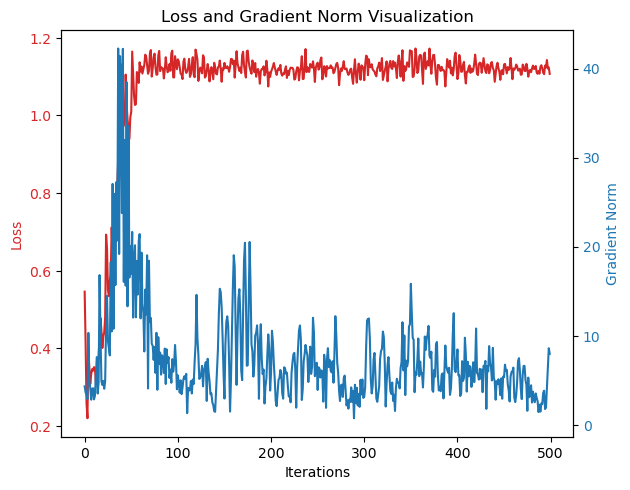

In [42]:
def chamfer_loss(x, y):
    loss_chamfer, _ = chamfer_distance(x,y)
    return loss_chamfer

def projected_chamfer_loss(x, y):
    loss_chamfer, _ = chamfer_distance(x,y)
    return loss_chamfer

def get_B_eye_rotation_matrices(B):
    # Create a batch of identity matrices
    return torch.eye(3).unsqueeze(0).expand(B, -1, -1)

def get_B_eye_quaternions(B):
    # Create a batch of identity matrices
    return torch.tensor([1,0,0,0]).float().unsqueeze(0).expand(B, -1)

class ConvergenceCheck():
    def __init__(self, threshold) -> None:
        self.previous_loss = None
        self.threshold = threshold

    def did_converge(self, loss):
        """
            This function takes the current and the loss of the previous iteration previous 
        """
        if self.threshold != None:
            if isinstance(loss, torch.Tensor):
                loss = loss.detach().cpu().numpy()

            if self.previous_loss == None:
                # Only for the first value
                self.previous_loss = loss
                return False
            else:
                if np.linalg.norm(self.previous_loss - loss) < self.threshold:
                    return True
                else:
                    self.previous_loss = loss
                    return False

def get_gradient_norm(t_params, quat_params):
    return torch.cat((t_params.grad, quat_params.grad), 1).norm(dim=-1)

def normalize_quat(quat, enable=False):
    """ Normalize tensor of quaterions to unit vectors
        This normalization can be seen as a constraint optimization of the strategy.
        args:
            quat: Matrix containing quaternions, BxNx4 Torch.tensor
            enable: Flag wheter normalize quat or not, bool
    """
    if enable:
        return quat / torch.norm(quat, p=2, dim=1, keepdim=True)
    else:
        return quat

# X and Y are both zero-centered at this point
def draw_registration_result_from_tensor(idx):
    # draw_registration_result(initialize_pointcloud(x[idx].detach().cpu().numpy()),
    #                         initialize_pointcloud(y[idx].detach().cpu().numpy()),
    #                         np.eye(4))

    draw_registration_result(initialize_pointcloud(x[idx].detach().cpu().numpy()),             # source
                             initialize_pointcloud(y_transformed[idx].detach().cpu().numpy()), # moving template
                             np.eye(4))

regMetric = RegistrationMetrics()

multiple_initial_value = False        # IN HOUV, this is known as the kernel. HOUV uses 64.
initialize_translation_zeros = True
show = True
show_initial_misaligment = 0
show_failed_cases = False
normalize_quat_flag = True
parameter_tracking = 1
select_best_score = 'F1-Score'
# 'F1-Score' uses argmax of F1-score
# 'CD' uses argmin of CD
# 'F1-Score+CD' uses decision rules with F1-Score and CD
# 'RMSE' uses argmin of inlier RMSE
percentage_threshold = 61 # % when using 'F1-Score+CD'
# is_early_stopping_at_convergence = False
convergence_threshold = None # 0.0005
opt = 'Adam' # Select from options: 'Adam', 'SDG', 'LBFGS'

for dd in range(0, 1):
    for idx in [4]:#range(1, 2): # range(0,39)
        # print("idx: ", idx)
        # CAD-based registration
        print(f'idx: {idx}')
        x, y, gt_R, gt_t = get_point_cloud_data(idx)
        print("y size:", y.shape)
        # Registration for 3D reconstruction
        # x1, y1, gt_R, gt_t = get_point_cloud_data(idx)
        # x2, y2, gt_R, gt_t = get_point_cloud_data(idx+1)
        # x=y1
        # y=y2

        # Zero-center source and target
        # x = subsample_x - subsample_x.mean(axis=1)
        # y = subsample_y - subsample_y.mean(axis=1)

        if multiple_initial_value:
            n_initial_quat, initial_quaternions = get_initial_quaternions()
            x = x.expand(n_initial_quat, -1, 3)
            y = y.expand(n_initial_quat, -1, 3)
        else:
            B = 1
            initial_quaternions = matrix_to_quaternion(get_B_eye_rotation_matrices(B)).requires_grad_()
            n_initial_quat = initial_quaternions.shape[0]


        lr = 0.055        # Learning rate, 0.055
        B = x.shape[0]    # Batch size
        K = 5             # Number of neighbors
        radius = 0.15     # Neighbors search radius
        gamma = 2         # Overlap loss constant
        alpha = 6         # Project loss constant
        epochs = 500      # No of epochs to run, 500
        scheculer_lr_decay = 0.9989 # Delay constant for lr scheduler, 0.993
        rg_mot_loss_coeff = 0       # Coefficient for the double registration rigid motion loss

        # rigid_motion_loss = RigidMotionLoss()
        f1_loss_function = F1ScoreLoss(radius*radius, K=K) # F1ScoreLossCount(radius*radius, K=K) #
        rmseLoss = RMSEInlierLoss()

        # Convergence check
        convergence = ConvergenceCheck(convergence_threshold)

        # Initialize quaternions:
        quat_params = initial_quaternions.requires_grad_()
        # print("Initial values of rotation: \n", quat_params)
        
        if initialize_translation_zeros == True:
            t_params = torch.zeros(B, 3, requires_grad=True)
        else:
            t = Transform3d().rotate(quaternion_to_matrix(quat_params)).to(device) # scale(s1_params).
            y_transformed = t.transform_points(y) #.float()
            InTranslation = -y_transformed.mean(axis=1).detach().cpu().numpy()
            t_params = torch.Tensor(InTranslation).requires_grad_()
        ##############

        if opt == 'Adam':
            optimizer = optim.Adam([t_params, quat_params], lr=lr)
            lr_decay_fnc = lambda epoch: scheculer_lr_decay ** epoch
            scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_decay_fnc)
        elif opt == 'SGD':
            print('SGD')
            optimizer = torch.optim.SGD([t_params, quat_params], lr=0.055)
        elif opt == 'LBFGS':
            optimizer = optim.LBFGS([t_params, quat_params], lr=0.920, history_size=10, max_iter=4, line_search_fn="strong_wolfe")
            # L-BFGS
            def closure():
                objective = chamfer_loss(x, y_transformed) + alpha * projected_chamfer_loss(x, y_transformed) \
                    + gamma * f1_loss_function(x, y_transformed)
                objective.backward()
                optimizer.zero_grad(set_to_none=True)
                return objective

        loss_tracking = []
        loss_tracking_minus = []
        grad_tracking = []

        start_time = time.time()
        reg_anim = RegistrationAnimation(device)

        for iter in range(epochs):

            t = Transform3d().rotate(quaternion_to_matrix(normalize_quat(quat_params, enable=normalize_quat_flag))).translate(t_params).to(device) # scale(s1_params).
            # t = Transform3d().rotate(quaternion_to_matrix(quat_params)).translate(t_params).to(device) # scale(s1_params).
            
            y_transformed = t.transform_points(y)

            # Forward pass and backward pass
            ####### RIGID MOTION LOSS #######
            # quat2mtx = quaternion_to_matrix(quat_params)
            # rig_mot_loss = rg_mot_loss_coeff * rigid_motion_loss(quat2mtx[0].view(1,3,3), t_params[0].view(1,1,3),
            #               quat2mtx[1].view(1,3,3), t_params[1].view(1,1,3))
            # rig_mot_loss = 0
            ################################

            loss = chamfer_loss(x, y_transformed) + alpha * projected_chamfer_loss(x, y_transformed) \
                + gamma * f1_loss_function(x, y_transformed)
                
            # + gamma * f1_loss_function(x, y_transformed)
            # chamfer_loss(x, y_transformed)
            # f1_loss_function(x, y_transformed)
            # dist(x.cuda(), y_transformed.cuda()).sum()
            # + rig_mot_loss
            if show_initial_misaligment and iter == 0:
                draw_registration_result_from_tensor(idx=0)

            loss.backward()

            # Parameter tracking
            if parameter_tracking:

                loss_ = chamfer_loss(x, y_transformed) + alpha * projected_chamfer_loss(x, y_transformed) \
                - gamma * f1_loss_function(x, y_transformed)

                loss_tracking.append(loss.cpu().detach().numpy())
                loss_tracking_minus.append(loss_.cpu().detach().numpy())
                grad_tracking.append(get_gradient_norm(t_params, quat_params).cpu().detach().numpy())

            # Update parameters using the optimizer
            # print("Params (before): ", t_params, quat_params)
            optimizer.step()

            # Zero out gradients for the next iteration
            optimizer.zero_grad(set_to_none=True) # False
            scheduler.step()

            if convergence.did_converge(loss.item()):
                print(f"Early stopping at iteration {iter}...")
                break

            # We will save images periodically and compose them into a GIF.
            # if iter % 10 == 0:
            #     reg_anim.add_frame(y_transformed[0], x[0])

        endtime = time.time()
        reg_runtime = endtime - start_time
        # Select best overlapping point cloud (F1-score by default)

        if select_best_score == 'CD':
            best_scores = chamfer_distance(x, y_transformed, batch_reduction=None)[0]
            idx_top_f1 = torch.argmin(best_scores)
        elif select_best_score == 'F1-Score':
            best_scores = f1_loss_function(x, y_transformed, reduction = None)
            idx_top_f1 = torch.argmax(best_scores)
        elif select_best_score == 'RMSE':
            best_scores = rmseLoss(x, y_transformed, batch_reduction=None)
            idx_top_f1 = torch.argmin(best_scores)
        elif select_best_score == 'F1-Score+CD':
            f1_scores = f1_loss_function(x, y_transformed, reduction = None)
            idx_top_f1 = torch.argmax(f1_scores)
            # print("F1-Scores")
            # print(f1_scores)
            print(f"Max F1-score: {idx_top_f1}, {f1_scores[idx_top_f1]}")

            # print("\nCD")
            cd_dist = chamfer_distance(x, y_transformed, batch_reduction=None)[0]
            # print(cd_dist)
            idx_top_cd = torch.argmin(chamfer_distance(x, y_transformed, batch_reduction=None)[0])

            print(f"CD of Min-CD: {idx_top_cd}, {cd_dist[idx_top_cd]}")
            print(f"CD of Max-F1: {idx_top_f1}, {cd_dist[idx_top_f1]}")
            print(f"F1-score of Min-CD: {idx_top_cd}, {f1_scores[idx_top_cd]}")
            
            if idx_top_f1 == idx_top_cd:
                # Case 1: Both selected cases of F1-Score and CD are the same
                idx_top_f1 = idx_top_f1
            else:
                percentage_cd_diff = 100*(cd_dist[idx_top_f1]-cd_dist[idx_top_cd])/cd_dist[idx_top_f1]
                print(f"Percentage difference between CD scores: {percentage_cd_diff}%\n")
                if percentage_cd_diff < percentage_threshold:
                    # Case 2: In the case the lowest CD is similar to that of the CD of the Max F1-Score
                    idx_top_f1 = idx_top_f1
                else:
                    # Case 3: In the case the lowest CD is significanly smaller than the CD of the Max F1-Score
                    idx_top_f1 = idx_top_cd

        print(f'Selected: {idx_top_f1}')
        print("--- %s seconds ---" % (reg_runtime))

        # reg_anim.end_animation()
        if parameter_tracking:
            # plot_accuracy_and_loss(loss_tracking, grad_tracking)
            plot_accuracy_and_loss(np.array(loss_tracking), np.linalg.norm(np.array(grad_tracking), axis=1))
        if show:
            draw_registration_result_from_tensor(idx=idx_top_f1)

        # Get predicted and gt values for metric
        pred_R = quaternion_to_matrix(quat_params[idx_top_f1]).view(1,3,3)
        pred_t = t_params[idx_top_f1].view(1,3)
        gt_R = gt_R.view(1,3,3)
        gt_t = gt_t.view(1,3)
        regMetric.add_values(pred_R, pred_t, gt_R, gt_t, reg_runtime)

        # Visualize only failed cases
        if show_failed_cases:
            # Net Metric object for individual checking of global optimal solution (GT)
            check_met = RegistrationMetrics()
            check_met.add_values(pred_R, pred_t, gt_R, gt_t)
            if check_met.get_all_metrics()['success_rate'] == 0:
                print(f"Failed case: {idx}")
                draw_registration_result_from_tensor(idx=idx_top_f1)
                break


In [43]:
regMetric.get_all_metrics()

{'r_mse': 0.23944509370190512,
 'r_rmse': 0.4893312719435629,
 'r_mae': 0.3163309666889873,
 't_mse': 0.04127903587858419,
 't_rmse': 0.2031724289331212,
 't_mae': 0.1970465162294548,
 'r_iso': array(0.84672886, dtype=float32),
 't_iso': array(0.351905, dtype=float32),
 'success_rate': 1.0,
 'n_runs': 1,
 'runtime': 8.499125480651855}

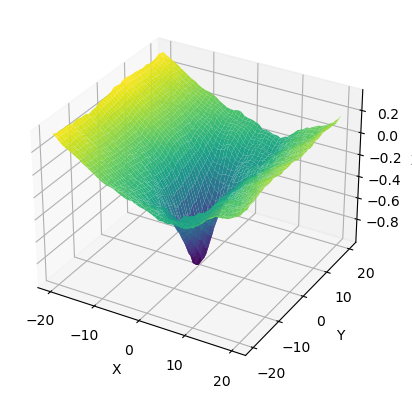

In [75]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def f(a, b):
    idx=idx_top_f1
    scr_tsr = copy.copy(x[idx].unsqueeze(0)) # source
    tgt_tsr = copy.copy(y_transformed[idx].unsqueeze(0)) # target

    # t = Transform3d().rotate(quaternion_to_matrix(normalize_quat(quat_params, enable=normalize_quat_flag))).translate(t_params).to(device) # scale(s1_params).

    const_ = 1/(1*20*np.pi/180)
    displacement = torch.Tensor([[a*const_,b*const_,0]])
    rotation_ = torch.Tensor([[0,a,b]])

    t = Transform3d().rotate(euler_angles_to_matrix(rotation_, convention='XYZ')).to(device)
    # t = Transform3d().translate(displacement).to(device)
   
    
    y_transformed_ = t.transform_points(tgt_tsr)

    loss = chamfer_loss(scr_tsr, y_transformed_) + alpha * projected_chamfer_loss(scr_tsr, y_transformed_) \
        - gamma * f1_loss_function(scr_tsr, y_transformed_)

    # draw_registration_result(initialize_pointcloud(scr_tsr[idx].detach().cpu().numpy()),             # source
    #                     initialize_pointcloud(y_transformed_[idx].detach().cpu().numpy()), # moving template
    #                     np.eye(4))

    return loss.cpu().detach().numpy()

# f(0,0)

# Generate linearly spaced values for x and y
# x_lin = np.linspace(-1, 1, 50)
# y_lin = np.linspace(-1, 1, 50)
x_lin = np.linspace(-20*np.pi/180, 20*np.pi/180, 50)
y_lin = np.linspace(-20*np.pi/180, 20*np.pi/180, 50)

# Create meshgrid for x and y
X, Y = np.meshgrid(x_lin, y_lin)

# Evaluate the function over the meshgrid
Z = np.zeros((X.shape[0], X.shape[0]))
for idx_a in range(X.shape[0]):
    for idx_b in range(X.shape[1]):
        Z[idx_a, idx_b] = f(X[idx_a, idx_b], Y[idx_a, idx_b])

X=X*180/np.pi
Y=Y*180/np.pi
# Plot the function in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X , Y, Z, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [54]:
# plot_accuracy_and_loss(np.array(loss_tracking), np.linalg.norm(np.array(grad_tracking), axis=1))
# plot_accuracy_and_loss(np.array(loss_tracking_minus), np.linalg.norm(np.array(grad_tracking), axis=1))

In [77]:
np.savetxt("X_euler_yz.csv", X,  delimiter = ",")
np.savetxt("Y_euler_yz.csv", Y,  delimiter = ",")
np.savetxt("Z_euler_yz.csv", Z,  delimiter = ",")

# np.savetxt("loss_tracking.csv", np.array(loss_tracking_minus),  delimiter = ",")
# np.savetxt("grad_tracking.csv", np.linalg.norm(np.array(grad_tracking), axis=1),  delimiter = ",")

In [163]:
################
f1_scores = f1_loss_function(x, y_transformed, reduction = None)
idx_top_f1 = torch.argmax(f1_scores)
################
draw_registration_result_from_tensor(idx=idx_top_f1)

print("F1-Scores")
print(f1_scores)
print(f"Max F1-score: {idx_top_f1}, {f1_scores[idx_top_f1]}")

print("\nCD")
cd_dist = chamfer_distance(x, y_transformed, batch_reduction=None)[0]
print(cd_dist)
idx_top_cd = torch.argmin(chamfer_distance(x, y_transformed, batch_reduction=None)[0])

print(f"CD of Min-CD: {idx_top_cd}, {cd_dist[idx_top_cd]}")
print(f"CD of Max-F1: {idx_top_f1}, {cd_dist[idx_top_f1]}")
print(f"F1-score of Min-CD: {idx_top_cd}, {f1_scores[idx_top_cd]}")

print("\nPercentage difference between CD scores:")
100*(cd_dist[idx_top_f1]-cd_dist[idx_top_cd])/cd_dist[idx_top_f1]

F1-Scores
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', grad_fn=<NanToNumBackward0>)
Max F1-score: 0, 0.0

CD
tensor([383.3101, 383.3101, 383.2545, 383.2544, 383.2544, 383.2545, 383.3102,
        383.3102, 383.2544, 383.3101, 383.3101, 383.3102, 383.3102, 403.0420,
        403.0420, 403.0420, 403.0419], device='cuda:0', grad_fn=<AddBackward0>)
CD of Min-CD: 3, 383.2543640136719
CD of Max-F1: 0, 383.31011962890625
F1-score of Min-CD: 3, 0.0

Percentage difference between CD scores:


tensor(0.0145, device='cuda:0', grad_fn=<DivBackward0>)

In [164]:
# Visualize all the seeds
for idx in range(n_initial_quat):
    # print(matrix_to_quaternion(euler_angles_to_matrix(rotations, "XYZ"))[idx])
    draw_registration_result_from_tensor(idx=idx)

In [760]:
x.shape, n_initial_quat

(torch.Size([17, 2048, 3]), 17)

In [ ]:
# source.estimate_normals(
#     search_param = o3d.geometry.KDTreeSearchParamHybrid(2, max_nn=30),
#     fast_normal_computation=False
# )

# target.estimate_normals(
#     search_param = o3d.geometry.KDTreeSearchParamHybrid(2, max_nn=30),
#     fast_normal_computation=False
# )

In [ ]:
# o3d.io.write_point_cloud(f"tv_source.ply", source, write_ascii=True)
# o3d.io.write_point_cloud(f"tv_target.ply", target, write_ascii=True)

True

In [ ]:
# tr = quaternion_multiply(R.from_matrix(gt_matrix[:3,:3]).as_quat(), np.array([0,0,0,1]))
# eye = np.eye(4)
# eye[:3,:3] = R.from_quat(tr).as_matrix()

In [ ]:
# max_angle_range = 30
# max_translation = 3

# def gen_source_targte():
#     PCD_DENSITY = 10000
#     source, target = GenerateSyntheticClouds.generate_source_target(
#         r'C:\Users\AlejandroHVilla\Downloads\Datasets\ModelNet10\ModelNet10\sofa\train\sofa_0660.off',
# #         r'C:\Users\AlejandroHVilla\Downloads\Datasets\ModelNet10\ModelNet10\monitor\train\monitor_0450.off',
#                                                                         PCD_DENSITY)
    
#     print(":: Point cloud dimensions: ", np.max(np.asarray(source.points), axis=0))
    
#     max_angle_range = 30
#     max_translation = 3
    
#     gt_matrix = MatrixPose.pose_to_matrix([random.randint(-max_translation,max_translation),
#                                               random.randint(-max_translation,max_translation),
#                                               random.randint(-max_translation,max_translation),
#                                               random.randint(-180,180),
#                                               random.randint(-max_angle_range,max_angle_range),
#                                               random.randint(-max_angle_range,max_angle_range)])

#     gt_euler = R.from_matrix(gt_matrix[:3,:3]).as_euler('ZYX', degrees=True)
#     print(":: Ground truth:\n", gt_matrix, '\n::Ground truth (Euler):\n', gt_euler)
#     target.transform(gt_matrix)

#     source_pts = np.asarray(source.points)
#     target_pts = np.asarray(target.points)
    
    
    
#     draw_registration_result(source, target, np.eye(4))
    
#     return source, target, source_pts, target_pts, gt_euler

# source, target, source_pts, target_pts, gt_euler = gen_source_targte()

:: Point cloud dimensions:  [18.17740059 44.29135132 17.23791576]
:: Ground truth:
 [[-0.99604297  0.05751173 -0.06775543  0.        ]
 [-0.01738599 -0.87374907 -0.48606615  0.        ]
 [-0.08715574 -0.48296477  0.87129152 -2.        ]
 [ 0.          0.          0.          1.        ]] 
::Ground truth (Euler):
 [-179.    5.  -29.]
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Controlador no válido. 


In [ ]:
# import numpy as np
# import itertools
# from scipy.spatial import cKDTree
# from scipy.spatial.transform import Rotation as R


# def overlap_loss(X, Y, R_quad, T_transl, threshold):
#     T = R.from_quat(R_quad).as_matrix()
#     X_transformed = (T[0:3, 0:3] @ X.T ).T + T_transl
#     tree = cKDTree(X_transformed)
#     searched_nn_points = tree.query_ball_point(Y, threshold, workers=-1)
#     searched_nn_points = list(itertools.chain(*searched_nn_points))
#     return len(searched_nn_points) / X_transformed.shape[0]

# def check_convergence(w0, w1, threshold = 0.00005):
#     return np.linalg.norm(w0-w1) < threshold

# grad_history = []
# loss_history = []

# def gradient_descent(X, Y, R_quad, T_transl, lr=0.01, max_iter=1000, tol=1e-3, threshold=100, callbacks=[]):
#     T = R_quad
#     Trl = T_transl
#     delta = 0.1

#     adam = AdamOptim(eta=lr, beta1=0.9, beta2=0.999, epsilon=1e-8)
#     step = 1
    
#     loss_history.append(-overlap_loss(X, Y, T, Trl, threshold))
    
#     for i in range(max_iter):
        
#         grad = np.zeros(7)
#         grad[0] = -(overlap_loss(X, Y, T + np.array([delta, 0, 0, 0]), np.array([0,0,0]), threshold) - overlap_loss(X, Y, T - np.array([delta, 0, 0, 0]), np.array([0,0,0]), threshold))/(2*delta)
#         grad[1] = -(overlap_loss(X, Y, T + np.array([0, delta, 0, 0]), np.array([0,0,0]), threshold) - overlap_loss(X, Y, T - np.array([0, delta, 0, 0]), np.array([0,0,0]), threshold))/(2*delta)
#         grad[2] = -(overlap_loss(X, Y, T + np.array([0, 0, delta, 0]), np.array([0,0,0]), threshold) - overlap_loss(X, Y, T - np.array([0, 0, delta, 0]), np.array([0,0,0]), threshold))/(2*delta)
#         grad[3] = -(overlap_loss(X, Y, T + np.array([0, 0, 0, delta]), np.array([0,0,0]), threshold) - overlap_loss(X, Y, T - np.array([0, 0, 0, delta]), np.array([0,0,0]), threshold))/(2*delta)
        
#         grad[4] = -(overlap_loss(X, Y, np.array([0, 0, 0, 1]), Trl + np.array([delta,0,0]), threshold) - overlap_loss(X, Y, np.array([0, 0, 0, 1]), Trl - np.array([delta,0,0]), threshold))/(2*delta)
#         grad[5] = -(overlap_loss(X, Y, np.array([0, 0, 0, 1]), Trl + np.array([0,delta,0]), threshold) - overlap_loss(X, Y, np.array([0, 0, 0, 1]), Trl - np.array([0,delta,0]), threshold))/(2*delta)
#         grad[6] = -(overlap_loss(X, Y, np.array([0, 0, 0, 1]), Trl + np.array([0,0,delta]), threshold) - overlap_loss(X, Y, np.array([0, 0, 0, 1]), Trl - np.array([0,0,delta]), threshold))/(2*delta)
        
#         grad_history.append(np.linalg.norm(grad))

#         T_old = np.append(T, Trl).copy()
#         T_all, _ = adam.update(step, w=np.append(T, Trl), b=0, dw=grad, db=0)
#         T = T_all[:4]
#         Trl = T_all[4:]
        
#         step += 1
#         loss_history.append(-overlap_loss(X, Y, T, Trl, threshold))
#         # T = T + lr * grad
        
#         # Check convergence
#         # obj_new = overlap_loss(X, Y, T_new, threshold)
        
#         if check_convergence(T_old, np.append(T, Trl), tol): #np.linalg.norm(grad) < tol:
#             print(f":: Tolerance reached at iter {i}!")
#             break

#         for c in callbacks:
#             c(T, np.array([0,0,0]))
        
#     return T, Trl

# best_rot, best_transl = gradient_descent(source_pts, target_pts, np.array([0., 0., 0., 1.]), np.array([0,0,0]),
#                             lr=0.1, max_iter=500, tol=0.005, threshold=1, callbacks=[])
# best_rot, best_transl

(array([0.11004634, 0.39401171, 0.09324152, 0.47509236]),
 array([-0.85399259,  0.72191244, -0.91459524]))

In [ ]:
# # Predicted transformation vs GT
# R.from_quat(best_rot).as_euler('ZYX', degrees=True), "gt_euler: ", gt_euler

(array([67.14786717, 61.73601322, 69.36331002]),
 'gt_euler: ',
 array([-179.,    5.,  -29.]))

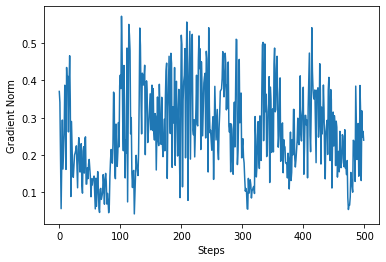

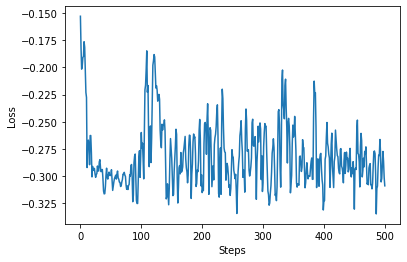

In [ ]:
# plt.plot(range(len(grad_history)), grad_history)
# plt.xlabel('Steps')
# plt.ylabel('Gradient Norm')
# plt.show()

# plt.plot(range(len(loss_history)), loss_history)
# plt.xlabel('Steps')
# plt.ylabel('Loss')
# plt.show()

In [ ]:
# eye = np.eye(4)
# eye[:3,:3] = R.from_quat(best_rot).as_matrix() 
# eye[:3,3] = best_transl
# # eye[:3,:3] = R.align_vectors(target_pts, source_pts)[0].as_matrix()
# draw_registration_result(source, target, eye)


# reg_checker_within_angular_limits(best_rot, [180, max_angle_range, max_angle_range]),
# reg_checker_within_roi(source, roi_params)

In [ ]:
# # Registration checkers
# roi_params = {'corner_x':  -100, 'corner_y':    100, 'corner_z':     100,
#               'dimension_x':200, 'dimension_y': 200, 'dimension_z': 200}

# # Within ROI
# def reg_checker_within_roi(transf_source, roi_params, n_points_exception=1):
#     """
#         args:
#             transf_source: o3d.pointcloud
#             roi_params: Dictionary defining the ROI
#         output:
#             checker: bool, True if a point cloud, e.g. transformed source, falls within roi, else False
    
#     """
#     cropped_pcd = ROI.crop_roi_box(transf_source, roi_params, inverse = True)
#     checker = np.asarray(cropped_pcd.points).shape[0] < n_points_exception
#     return checker

# # Within expected angular range
# def reg_checker_within_angular_limits(reg_trans, max_euler_angles):
#     """
#         args:
#             reg_trans: np.ndarray, 4x4 homogeneous, 3x3 rotation matrix, (4,) quaterion or (3,) euler
#             max_euler_angles: Maximum rotation given in Euler ZYX
#         output:
#             checker: bool, True if transformation angles fall within allowable limits, else False
#     """
#     reg_trans = np.asarray(reg_trans)
#     max_euler_angles = np.abs(np.asarray(max_euler_angles))[:3]
    
#     if reg_trans.shape == (4,):
#         # Quaternion
#         reg_trans_euler = R.from_quat(reg_trans).as_euler('ZYX', degrees=True)
    
#     elif reg_trans.shape == (3,):
#         # Euler angle ZYX
#         reg_trans_euler = reg_trans
    
#     elif reg_trans.shape[0] <= 4 and reg_trans.shape[1] <= 4:
#         # Rotation matrix
#         reg_trans_euler = R.from_matrix(reg_trans[:3,:3]).as_euler('ZYX', degrees=True)
    
#     print(f":: Reg Checker Angle Limits: {reg_trans_euler} within +- {max_euler_angles}")
#     checker = not np.any(np.logical_and(reg_trans_euler > max_euler_angles, reg_trans_euler < -max_euler_angles))
#     return checker
    


In [ ]:
# # Penalty to deviate from orthogonality:
    
# def loss_orthogonality(alpha, R):
#     if R.shape == (4,4):
#         R = R[:3, :3]
#     return alpha * np.linalg.norm(R.T @ R - np.eye(4))

In [ ]:
# def get_mesh_from_pcd(pcd):
    
#     pcd.estimate_normals(
#         search_param = o3d.geometry.KDTreeSearchParamHybrid(20, max_nn=30),
#         fast_normal_computation=False
#     )
    
#     return o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,
#                                                                            o3d.utility.DoubleVector([0.5,5,10,15,20]))


# mesh = get_mesh_from_pcd(source)

# mesh.get_surface_area()

In [ ]:
# draw_registration_result(mesh, target, eye)

In [ ]:
# ########

# import numpy as np

# def gradient_descent(points1, points2, num_iterations, learning_rate):
#     """
#     Maximizes overlap between two surfaces as point clouds using gradient descent.

#     Args:
#         points1 (numpy array): Point cloud of surface 1
#         points2 (numpy array): Point cloud of surface 2
#         num_iterations (int): Number of iterations to run gradient descent
#         learning_rate (float): Learning rate to use for gradient descent

#     Returns:
#         numpy array: Translation vector that maximizes overlap between the two surfaces
#     """
#     # Initialize translation vector to zero
#     translation = np.zeros((3,))

#     # Loop over the specified number of iterations
#     for i in range(num_iterations):
#         # Compute the gradient of the overlap function with respect to the translation vector
#         gradient = compute_gradient(points1, points2, translation)

#         # Update the translation vector using gradient descent
#         translation -= learning_rate * gradient

#     # Return the final translation vector
#     return translation


# def compute_gradient(points1, points2, translation):
#     """
#     Computes the gradient of the overlap function with respect to the translation vector.

#     Args:
#         points1 (numpy array): Point cloud of surface 1
#         points2 (numpy array): Point cloud of surface 2
#         translation (numpy array): Translation vector

#     Returns:
#         numpy array: Gradient of the overlap function with respect to the translation vector
#     """
#     # Compute the transformed point cloud for surface 1
#     transformed_points1 = points1 + translation

#     # Compute the overlap between the two point clouds
#     overlap = compute_overlap(transformed_points1, points2)

#     # Compute the gradient of the overlap function with respect to the translation vector
#     gradient = np.zeros((3,))
#     for i in range(3):
#         delta = np.zeros((3,))
#         delta[i] = 1
#         translation_plus_delta = translation + delta
#         transformed_points1_plus_delta = points1 + translation_plus_delta
#         overlap_plus_delta = compute_overlap(transformed_points1_plus_delta, points2)
#         gradient[i] = (overlap_plus_delta - overlap) / learning_rate

#     # Return the gradient
#     return gradient


# def compute_overlap(points1, points2):
#     """
#     Computes the overlap between two point clouds.

#     Args:
#         points1 (numpy array): Point cloud of surface 1
#         points2 (numpy array): Point cloud of surface 2

#     Returns:
#         float: Overlap between the two point clouds
#     """
#     # Compute the distance between each point in point cloud 1 and the nearest point in point cloud 2
#     distances = np.zeros((points1.shape[0],))
#     for i in range(points1.shape[0]):
#         distances[i] = np.min(np.linalg.norm(points1[i] - points2, axis=1))

#     # Compute the overlap as the sum of the distances
#     overlap = np.sum(distances)

#     # Return the overlap
#     return overlap

In [ ]:
# def quaternion_multiply(quaternion1, quaternion0):
#     w0, x0, y0, z0 = quaternion0
#     w1, x1, y1, z1 = quaternion1
#     return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
#                      x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
#                      -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
#                      x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)


# def daction3(pt, mat):
#     '''derivative of SE(3) transformation of a 3D point'''
#     R = mat[0:3, 0:3]
#     skew_sym_p = np.array([
#         [0.0, -pt[2], pt[1]],
#         [pt[2], 0.0, -pt[0]],
#         [-pt[1], pt[0], 0.0]
#     ])
#     rmat = np.dot(-R, skew_sym_p)
#     return np.array([
#         [R[0, 0], R[0, 1], R[0, 2], rmat[0, 0], rmat[0, 1], rmat[0, 2]],
#         [R[1, 0], R[1, 1], R[1, 2], rmat[1, 0], rmat[1, 1], rmat[1, 2]],
#         [R[2, 0], R[2, 1], R[2, 2], rmat[2, 0], rmat[2, 1], rmat[2, 2]]
#     ])

# daction3(np.array([1,2,3]), np.eye(4))

# # array([0., 0., 0., 1.]) quaternion of the identity matrix
# # r.as_euler('ZYX', degrees=True)

In [ ]:
# source, target, source_pts, target_pts = gen_source_targte()

# voxel_size = 1
# source_ = copy.deepcopy(source).voxel_down_sample(voxel_size)
# target_ = copy.deepcopy(target).voxel_down_sample(voxel_size)

# start_time = time.time()

# gen_icp = ICP_Generalized()
# gen_icp.set_parameters(max_correspondence_distance=50)
# # cCReg = ZeroCenterRegistration()
# # cCReg.set_parameters(gen_icp)

# new_reg_trans, _ = gen_icp.register(copy.deepcopy(source_),
#                                   copy.deepcopy(target_) )

# draw_registration_result(source_, target_, new_reg_trans)

# # print(":: Metric: ", RegistrationMetric.get_overlap_ratio(source_, target_, 3, new_reg_trans))
# print("--- %s seconds ---" % (time.time() - start_time))